Notebook credits: [super_gradient](https://github.com/Deci-AI/super-gradients/blob/master/notebooks/YoloNAS_Pose_Fine_Tuning_Animals_Pose_Dataset.ipynb)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -qq super-gradients
!pip install -qq gdown==4.6.0 torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 20.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.3/108.3 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.9/913.9 kB 41.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 32.5 M

**Importing all the required libraries**

In [ ]:
# Standard library imports
import gc
import os
import json
import random
from tqdm import tqdm
from pathlib import Path
from pprint import pprint
from typing import Any, List, Tuple, Union

# Third-party imports
import cv2
import yaml
import gdown
import torch
import json_tricks
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Colab specific imports
from google.colab.patches import cv2_imshow

# Super-Gradients imports
from super_gradients.training import models
from super_gradients.common.object_names import Models
from super_gradients.training import Trainer
from super_gradients.common.decorators.factory_decorator import resolve_param
from super_gradients.common.factories.transforms_factory import TransformsFactory
from super_gradients.common.object_names import Datasets
from super_gradients.training.transforms.keypoint_transforms import AbstractKeypointTransform
from super_gradients.training.samples import PoseEstimationSample
from super_gradients.common.environment.ddp_utils import get_local_rank
from super_gradients.training.utils.distributed_training_utils import wait_for_the_master
from super_gradients.training.datasets.pose_estimation_datasets.abstract_pose_estimation_dataset import AbstractPoseEstimationDataset
from super_gradients.training.datasets.pose_estimation_datasets import YoloNASPoseCollateFN
from super_gradients.training.transforms.keypoints import (
    KeypointsRandomHorizontalFlip,
    KeypointsHSV,
    KeypointsBrightnessContrast,
    KeypointsMosaic,
    KeypointsRandomAffineTransform,
    KeypointsLongestMaxSize,
    KeypointsPadIfNeeded,
    KeypointsImageStandardize,
    KeypointsImageNormalize,
    KeypointsRemoveSmallObjects
)
from super_gradients.training.models.pose_estimation_models.yolo_nas_pose import YoloNASPosePostPredictionCallback
from super_gradients.training.utils.callbacks import ExtremeBatchPoseEstimationVisualizationCallback, Phase
from super_gradients.training.utils.early_stopping import EarlyStop
from super_gradients.training.metrics import PoseEstimationMetrics
import omegaconf as oc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('[device]', device)


The console stream is logged into /root/sg_logs/console.log


[2024-08-02 06:09:36] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


In [ ]:
#@title Common Dataset Functions

SKELETON_LINK_COLORS = [
    [255, 128, 0],
    [255, 128, 0],
    [255, 128, 0],
    [255, 128, 0],
    [255, 153, 255],
    [255, 153, 255],
    [255, 153, 255],
    [255, 153, 255],
    [102, 178, 255],
    [102, 178, 255],
    [102, 178, 255],
    [102, 178, 255],
    [255, 51, 51],
    [255, 51, 51],
    [255, 51, 51],
    [255, 51, 51],
    [0, 255, 0],
    [0, 255, 0],
    [0, 255, 0],
    [0, 255, 0]
]
KEYPOINT_COLORS = [
    [255, 255, 255],
    [255, 128, 0],
    [255, 128, 0],
    [255, 128, 0],
    [255, 128, 0],
    [255, 153, 255],
    [255, 153, 255],
    [255, 153, 255],
    [255, 153, 255],
    [102, 178, 255],
    [102, 178, 255],
    [102, 178, 255],
    [102, 178, 255],
    [255, 51, 51],
    [255, 51, 51],
    [255, 51, 51],
    [255, 51, 51],
    [0, 255, 0],
    [0, 255, 0],
    [0, 255, 0],
    [0, 255, 0]
]
print('[SKELETON_LINK_COLORS]', len(SKELETON_LINK_COLORS))
print('[KEYPOINT_COLORS]', len(KEYPOINT_COLORS))

def visualize_sg_annotations(images_path, annotation_json_path, N=5):
    keypoints = json.load(open(annotation_json_path, 'r', encoding='utf-8'))
    images_list = keypoints['images']
    categories_map = {cat_obj['id']: cat_obj for cat_obj in keypoints['categories']}
    chosen_indices = np.random.choice(list(images_list.keys()), size=N).astype(np.int64)
    print('[chosen_indices]', chosen_indices)

    for idx in chosen_indices:
        image_path = os.path.join(images_path, images_list[str(idx)])
        image = cv2.imread(image_path)
        h, w, _ = image.shape

        for ann in keypoints['annotations']:
            if ann['image_id'] == idx:
                x1, y1, x2, y2 = ann['bbox']
                x1 = min(w, max(x1, 0))
                y1 = min(h, max(y1, 0))
                x2 = min(w, max(x2, 0))
                y2 = min(h, max(y2, 0))
                category_obj = categories_map[ann['category_id']]
                # print('[category_obj]', category_obj, x1, y1, x2, y2)
                cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), thickness=2, lineType=cv2.LINE_AA)

                for i, kpt in enumerate(ann['keypoints']):
                    if kpt[2]:
                        # cv2.putText(image, keypoints_tag[i], (int(kpt[0]), int(kpt[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
                        cv2.putText(image, str(i), kpt[:2], cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv2.LINE_AA)
                        cv2.circle(image, kpt[:2], radius=4, color=KEYPOINT_COLORS[i], thickness=-1, lineType=cv2.LINE_AA)
                for j, pair in enumerate(category_obj['skeleton']):
                    pt1 = ann['keypoints'][pair[0]]
                    pt2 = ann['keypoints'][pair[1]]
                    if pt1[2] and pt2[2]:
                        # cv2.putText(image, str(j), pt2[:2], cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv2.LINE_AA)
                        cv2.line(image, pt1[:2], pt2[:2], color=SKELETON_LINK_COLORS[j], thickness=1, lineType=cv2.LINE_AA)

        cv2_imshow(image)


[device] cuda
[SKELETON_LINK_COLORS] 20
[KEYPOINT_COLORS] 21


# Setup for Dataset

In [ ]:
!pip3 install -qq json_tricks

Download Dataset

In [ ]:
!gdown "1UT4mwkyN8cnUN6AQo2aday8-fYqhsu0D" # &> /dev/null #Hand Image Data

Downloading...
From: https://drive.google.com/uc?id=1UT4mwkyN8cnUN6AQo2aday8-fYqhsu0D
To: /content/RightLeftCombined_Cropped.zip
100% 8.21G/8.21G [01:57<00:00, 69.7MB/s]


In [ ]:
!gdown "1K3ngobAqhrwaVBMiFPd-iNKbzdnLRl3w" #&> /dev/null #Json files


Downloading...
From: https://drive.google.com/uc?id=1K3ngobAqhrwaVBMiFPd-iNKbzdnLRl3w
To: /content/mmpose_outputs_json.zip
100% 9.54M/9.54M [00:00<00:00, 56.5MB/s]


Unzip and prepare directory structure

In [ ]:
!rm -rf "mmpose_outputs_json"
!mkdir "mmpose_outputs_json"
!unzip -oj "/content/mmpose_outputs_json.zip" -d "mmpose_outputs_json" &> /dev/null

In [ ]:
!rm -rf "dataset"
!mkdir "dataset"
!mkdir "dataset/images"
!unzip -oj "RightLeftCombined_Cropped.zip" -d "dataset/images" &> /dev/null
!rm -rf "dataset/__MACOSX"
!rm 'dataset/images/screenshot_20240117_191228.png'

In [ ]:
!ls -l "dataset/images" | wc -l

## Global variables

In [ ]:
HAND_IMAGES_PATH = Path('/content/dataset/images')
HAND_IMAGES_PATH2 = Path('/content/dataset/images2')
os.makedirs(HAND_IMAGES_PATH2, exist_ok=True)
MMPOSE_OUTPUTS_PATH = Path('/content/mmpose_outputs_json')
json_filenames = os.listdir(MMPOSE_OUTPUTS_PATH)
data = json_tricks.load(str(MMPOSE_OUTPUTS_PATH/json_filenames[0]))


HAND_KEYPOINT_NAMES = list(data['meta_info']['keypoint_name2id'].keys())
KEYPOINT_COLORS = data['meta_info']['keypoint_colors'].tolist()
NUM_SKELETON_LINKS = data['meta_info']['num_skeleton_links']
SKELETON_LINKS = data['meta_info']['skeleton_links']
SKELETON_LINK_COLORS = data['meta_info']['skeleton_link_colors'].tolist()
print('[HAND_KEYPOINT_NAMES]', type(HAND_KEYPOINT_NAMES))
print('[KEYPOINT_COLORS]', type(KEYPOINT_COLORS))
print('[NUM_SKELETON_LINKS]', type(NUM_SKELETON_LINKS))
print('[SKELETON_LINKS]', type(SKELETON_LINKS))
print('[SKELETON_LINK_COLORS]', type(SKELETON_LINK_COLORS))


## Convert MMPose outputs to Super-Gradients JSON format

In [ ]:
json_dataset = {
    "info": {},
    "categories": [
        {
            "supercategory": "person",
            "id": 0,
            "name": "hand",
            "keypoints": HAND_KEYPOINT_NAMES,
            "skeleton": SKELETON_LINKS,
        }
    ],
    "images": {},
    "annotations": []
}

image_filnames = os.listdir(HAND_IMAGES_PATH)
image_filnames = list(filter(lambda x: not x.startswith('.') and x.endswith('.png'), image_filnames))
print('[image_filnames]', len(image_filnames))
for idx, image_name in tqdm(enumerate(image_filnames), total=len(image_filnames)):
    # load image
    image_path = HAND_IMAGES_PATH / image_name
    image = cv2.imread(str(image_path))
    # reduce image size between (640, 640)
    h, w, c = image.shape
    r = max(640 / h, 640 / w)
    image = cv2.resize(image, dsize=None, fx=r, fy=r)
    # save resized image
    image_name, ext = os.path.splitext(image_name)
    out_image_name = image_name + '.jpg'
    cv2.imwrite(str(HAND_IMAGES_PATH2 / out_image_name), image)

    # add current image to json_dataset['images']
    image_id = idx + 1
    json_dataset['images'][str(image_id)] = out_image_name

    # process current image annotations
    json_filename = f"results_{os.path.splitext(image_name)[0]}.json"
    mmpose_result = json_tricks.load(str(MMPOSE_OUTPUTS_PATH/json_filename))
    keypoints = np.array(mmpose_result['instance_info'][0]['keypoints']) * r
    keypoints = np.hstack([keypoints, np.ones_like(keypoints, shape=(len(keypoints), 1))])
    bbox = np.array(mmpose_result['instance_info'][0]['bbox']) * r
    # add current image related annotations to json_dataset['annotations']
    json_dataset['annotations'].append({
        "image_id": image_id,
        "bbox": bbox.astype(np.int64).flatten().tolist(),
        "keypoints": keypoints.astype(np.int64).tolist(),
        "num_keypoints": len(keypoints),
        "category_id": 0
    })

# save annotations in super-gradients format
json.dump(json_dataset, open('/content/sg_hand_keypoints.json', 'w'), indent=4)


[image_filnames] 5016


100%|██████████| 5016/5016 [06:51<00:00, 12.19it/s]


Visualize and validate the annotation conversion

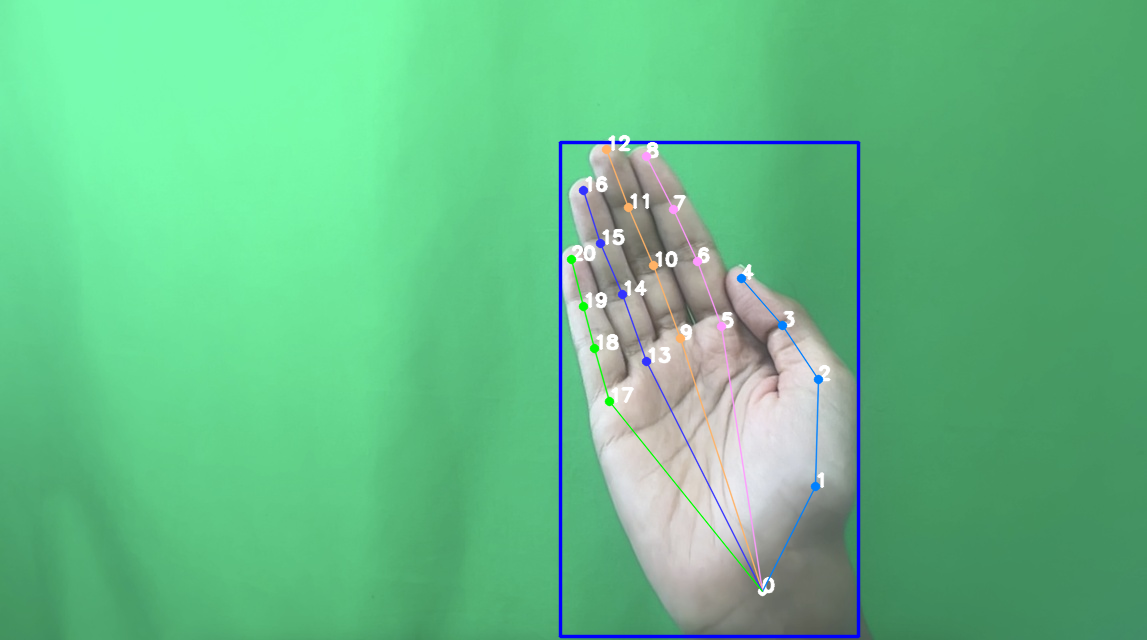

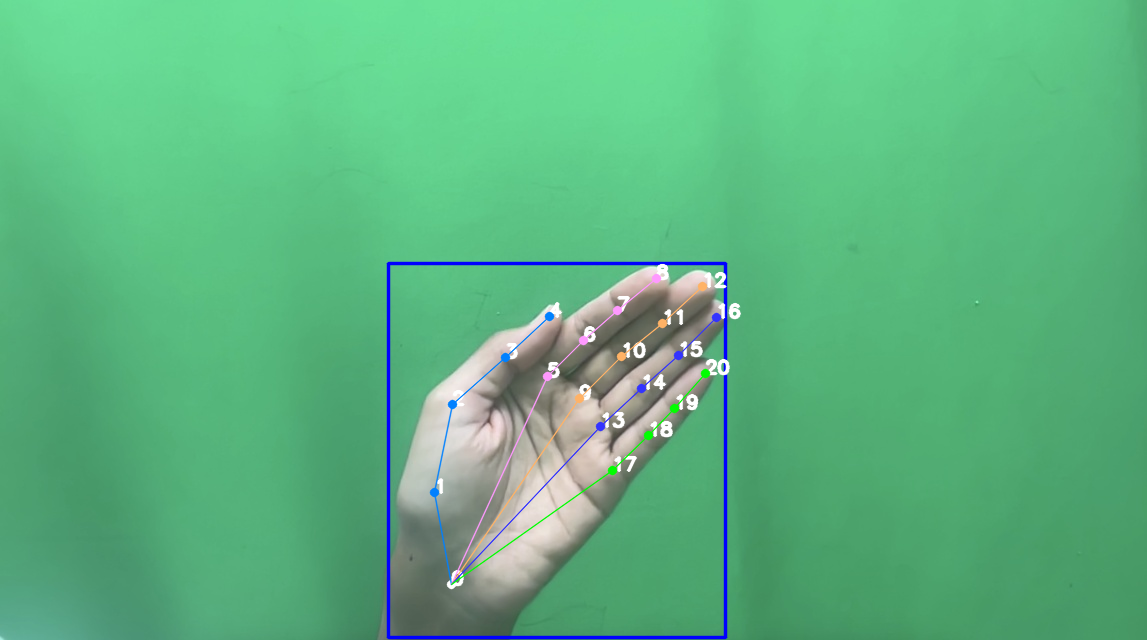

[chosen_indices] [3568 3262 4183 1233 4209]


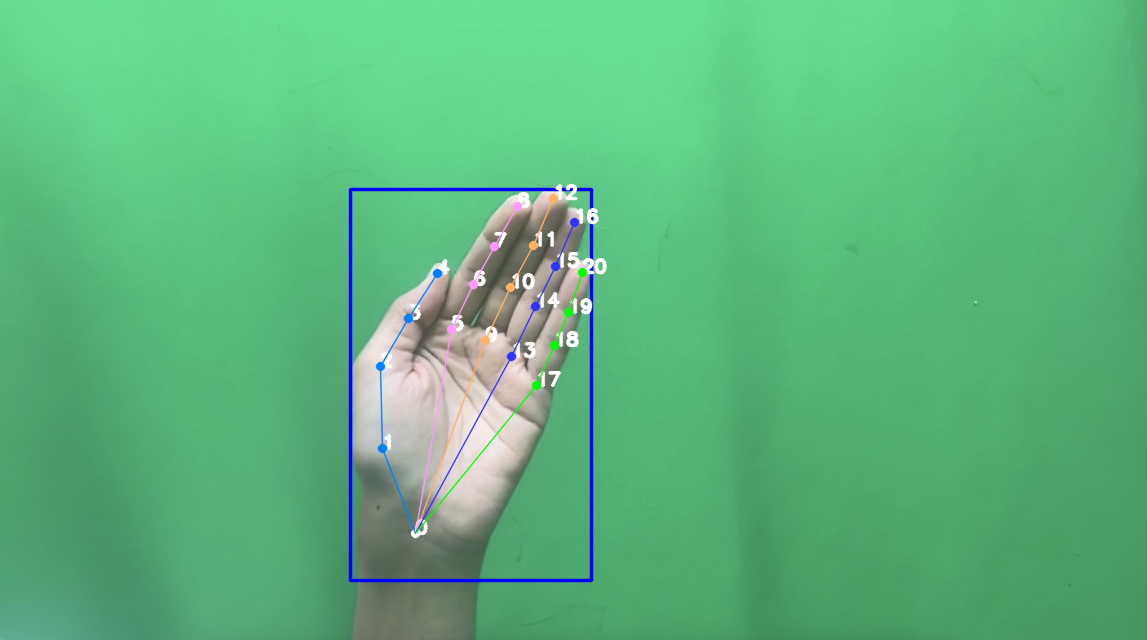

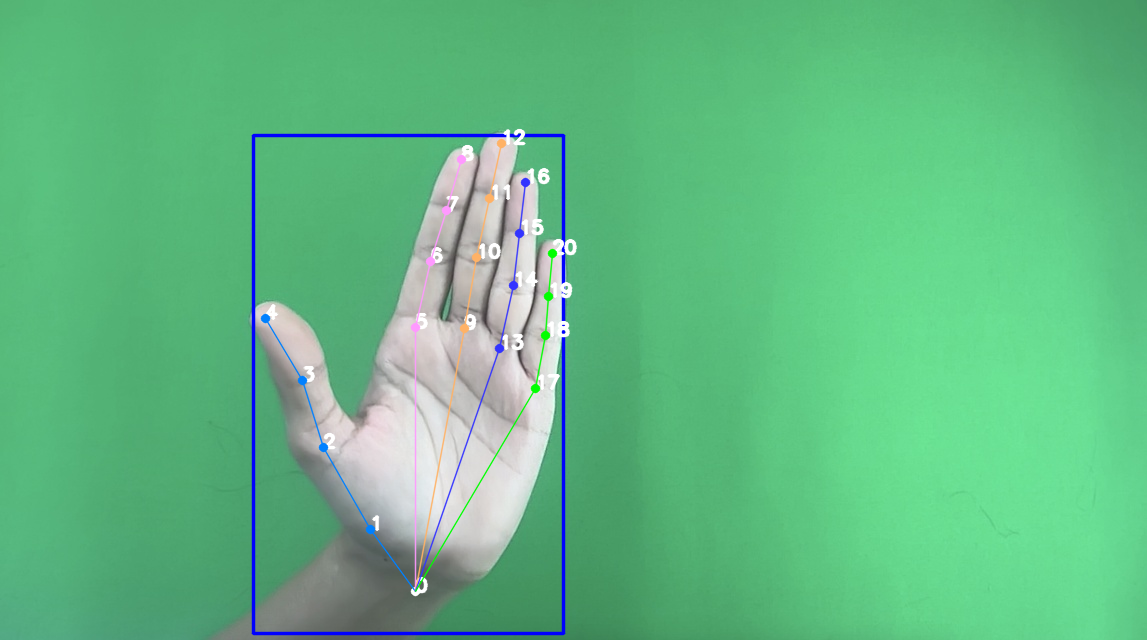

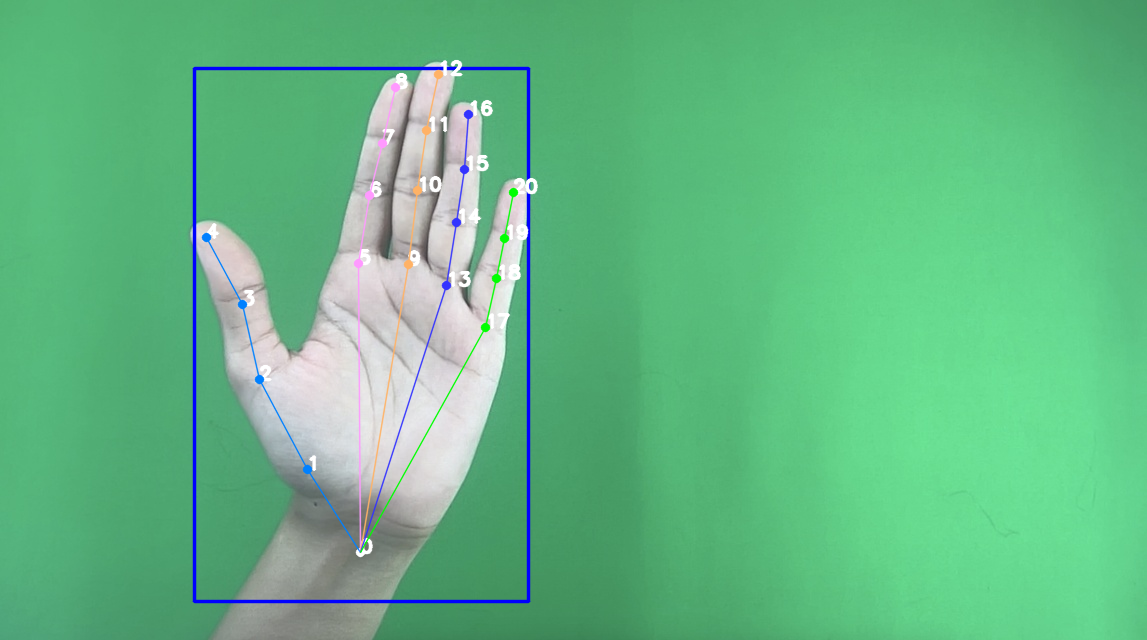

In [ ]:
visualize_sg_annotations('/content/dataset/images2', '/content/sg_hand_keypoints.json', N=5)

## Write YAML file for Custom Dataset Training

In [ ]:
%%writefile "/content/hand_pose_estimation_yolo_nas_dataset_params.yaml"
num_joints: 21

#We donot have exact sigma scores, so we use values 0.1 for all keypoints.
oks_sigmas: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

flip_indexes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

edge_links:
    - [0, 1]
    - [1, 2]
    - [2, 3]
    - [3, 4]
    - [0, 5]
    - [5, 6]
    - [6, 7]
    - [7, 8]
    - [0, 9]
    - [9, 10]
    - [10, 11]
    - [11, 12]
    - [0, 13]
    - [13, 14]
    - [14, 15]
    - [15, 16]
    - [0, 17]
    - [17, 18]
    - [18, 19]
    - [19, 20]

edge_colors:
    - [255, 128, 0]
    - [255, 128, 0]
    - [255, 128, 0]
    - [255, 128, 0]
    - [255, 153, 255]
    - [255, 153, 255]
    - [255, 153, 255]
    - [255, 153, 255]
    - [102, 178, 255]
    - [102, 178, 255]
    - [102, 178, 255]
    - [102, 178, 255]
    - [255, 51, 51]
    - [255, 51, 51]
    - [255, 51, 51]
    - [255, 51, 51]
    - [0, 255, 0]
    - [0, 255, 0]
    - [0, 255, 0]
    - [0, 255, 0]

keypoint_colors:
    - [255, 255, 255]
    - [255, 128, 0]
    - [255, 128, 0]
    - [255, 128, 0]
    - [255, 128, 0]
    - [255, 153, 255]
    - [255, 153, 255]
    - [255, 153, 255]
    - [255, 153, 255]
    - [102, 178, 255]
    - [102, 178, 255]
    - [102, 178, 255]
    - [102, 178, 255]
    - [255, 51, 51]
    - [255, 51, 51]
    - [255, 51, 51]
    - [255, 51, 51]
    - [0, 255, 0]
    - [0, 255, 0]
    - [0, 255, 0]
    - [0, 255, 0]

image_size: 640
dataset_params_suffix: "${dataset_params.image_size}"

train_dataset_params:
    data_dir: /content/dataset # root path to coco data
    images_dir: images
    json_file: sg_hand_train_keypoints.json

    edge_links: ${dataset_params.edge_links}
    edge_colors: ${dataset_params.edge_colors}
    keypoint_colors: ${dataset_params.keypoint_colors}

    transforms:
        - KeypointsRandomHorizontalFlip:
            flip_index: ${dataset_params.flip_indexes}
            prob: 0.5

        - KeypointsHSV:
            prob: 0.5
            hgain: 20
            sgain: 20
            vgain: 20

        - KeypointsBrightnessContrast:
            prob: 0.5
            brightness_range: [ 0.8, 1.2 ]
            contrast_range: [ 0.8, 1.2 ]

        - KeypointsMosaic:
            prob: 0.8

        - KeypointsRandomAffineTransform:
            max_rotation: 0
            min_scale: 0.5
            max_scale: 1.5
            max_translate: 0.1
            image_pad_value: 127
            mask_pad_value: 1
            prob: 0.75
            interpolation_mode: [ 0, 1, 2, 3, 4 ]

        - KeypointsLongestMaxSize:
            max_height: ${dataset_params.image_size}
            max_width: ${dataset_params.image_size}

        - KeypointsPadIfNeeded:
            min_height: ${dataset_params.image_size}
            min_width: ${dataset_params.image_size}
            image_pad_value: [ 127, 127, 127 ]
            mask_pad_value: 1
            padding_mode: center

        - KeypointsImageStandardize:
            max_value: 255

        - KeypointsImageNormalize:
            mean: [ 0.485, 0.456, 0.406 ]
            std: [ 0.229, 0.224, 0.225 ]

        - KeypointsRemoveSmallObjects:
            min_instance_area: 1
            min_visible_keypoints: 1

val_dataset_params:
    data_dir: /content/dataset
    images_dir: images
    json_file: sg_hand_val_keypoints.json

    edge_links: ${dataset_params.edge_links}
    edge_colors: ${dataset_params.edge_colors}
    keypoint_colors: ${dataset_params.keypoint_colors}

    transforms:
        - KeypointsLongestMaxSize:
            max_height: ${dataset_params.image_size}
            max_width: ${dataset_params.image_size}

        - KeypointsPadIfNeeded:
            min_height: ${dataset_params.image_size}
            min_width: ${dataset_params.image_size}
            image_pad_value: 127
            mask_pad_value: 1
            padding_mode: bottom_right

        - KeypointsImageStandardize:
            max_value: 255

        - KeypointsImageNormalize:
            mean: [ 0.485, 0.456, 0.406 ]
            std: [ 0.229, 0.224, 0.225 ]


train_dataloader_params:
    dataset: HandPoseEstimationDataset
    shuffle: True
    batch_size: 32
    num_workers: 8
    drop_last: True
    pin_memory: False
    collate_fn: YoloNASPoseCollateFN

val_dataloader_params:
    dataset: HandPoseEstimationDataset
    batch_size: 32
    num_workers: 8
    drop_last: False
    pin_memory: False
    collate_fn: YoloNASPoseCollateFN


Writing /content/hand_pose_estimation_yolo_nas_dataset_params.yaml


In [ ]:
yolo_nas_pose = models.get("yolo_nas_pose_s", pretrained_weights="coco_pose")

[2024-08-02 06:26:56] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco_pose dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-08-02 06:26:56] INFO - checkpoint_utils.py - License Notification: YOLO-NAS-POSE pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS-POSE.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_pose_s_coco_pose.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_pose_s_coco_pose.pth
100%|██████████| 85.3M/85.3M [00:02<00:00, 40.9MB/s]
[

In [ ]:
from torchinfo import summary

summary(model=yolo_nas_pose,
        input_size=(16, 3, 640, 640),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
YoloNASPose_S (YoloNASPose_S)                                     [16, 3, 640, 640]    [16, 8400, 4]        --                   True
├─NStageBackbone (backbone)                                       [16, 3, 640, 640]    [16, 96, 160, 160]   --                   True
│    └─YoloNASStem (stem)                                         [16, 3, 640, 640]    [16, 48, 320, 320]   --                   True
│    │    └─QARepVGGBlock (conv)                                  [16, 3, 640, 640]    [16, 48, 320, 320]   3,024                True
│    └─YoloNASStage (stage1)                                      [16, 48, 320, 320]   [16, 96, 160, 160]   --                   True
│    │    └─QARepVGGBlock (downsample)                            [16, 48, 320, 320]   [16, 96, 160, 160]   88,128               True
│    │    └─YoloNASCSPLayer (blocks)                     

In [ ]:
CHECKPOINT_DIR = '/content/drive/MyDrive/python/ai-pointer'
trainer = Trainer(experiment_name='hand_pose-007-yolo_nas_n', ckpt_root_dir=CHECKPOINT_DIR)

In [ ]:
# @title
def open_file(file_path: str) -> Union[dict, list, None]:
    """
    Opens and reads the content of a JSON or YAML file.

    Parameters:
    file_path (str): The path to the file.

    Returns:
    Union[dict, list, None]: The content of the file parsed to a dictionary or a list,
                             or None if an error occurs.
    """
    try:
        with open(file_path, 'r') as file:
            if file_path.endswith('.json'):
                return json.load(file)
            elif file_path.endswith('.yaml') or file_path.endswith('.yml'):
                return yaml.safe_load(file)
            else:
                raise ValueError(f'Unsupported file format: {file_path}')
    except Exception as e:
        print(f'An error occurred: {e}')
        return None

# Usage:
annotations = open_file('/content/sg_hand_keypoints.json')
config = open_file('/content/hand_pose_estimation_yolo_nas_dataset_params.yaml')

In [ ]:
#`HandPoseEstimationDataset` class is implemented

class HandPoseEstimationDataset(AbstractPoseEstimationDataset):
    """
    Dataset class for training pose estimation models on Hand Pose dataset.
    """

    @classmethod
    def split_hand_pose_dataset(cls, annotation_file: str, train_annotation_file: str, val_annotation_file: str, val_fraction: float):
        """
        Split the Hand Pose dataset into training and validation sets.

        :param annotation_file: Path to the JSON file containing all annotations.
        :param train_annotation_file: Path where the annotations for the training set will be saved.
        :param val_annotation_file: Path where the annotations for the validation set will be saved.
        :param val_fraction: Fraction of the total dataset to be used for validation.
        """
        # Open and load the entire annotations JSON file
        with open(annotation_file, "r") as f:
            annotation = json.load(f)

        # Extract image IDs from the annotations
        image_ids = list(annotation["images"].keys())

        # Extract labels for each image to be used for stratified splitting
        # (ensures a balanced class distribution in train and validation sets)
        labels = [[ann["category_id"] for ann in annotation["annotations"] if ann["image_id"] == image_id] for image_id in image_ids]
        labels = [label[0] if len(label) else -1 for label in labels]  # Choose the first label if present, else assign -1

        # Split the dataset into training and validation sets
        train_ids, val_ids = train_test_split(image_ids, test_size=val_fraction, random_state=42, stratify=labels)

        # Prepare annotations dictionary for training set
        train_annotations = {
            "info": annotation["info"],
            "categories": annotation["categories"],
            "images": dict((image_id, annotation["images"][image_id]) for image_id in train_ids),
            "annotations": [ann for ann in annotation["annotations"] if str(ann["image_id"]) in train_ids],
        }

        # Prepare annotations dictionary for validation set
        val_annotations = {
            "info": annotation["info"],
            "categories": annotation["categories"],
            "images": dict((image_id, annotation["images"][image_id]) for image_id in val_ids),
            "annotations": [ann for ann in annotation["annotations"] if str(ann["image_id"]) in val_ids],
        }

        # Save the annotations for the training set to a JSON file
        with open(train_annotation_file, "w") as f:
            json.dump(train_annotations, f)
            print("Train annotations saved to", train_annotation_file)
            print("Train images:", len(train_ids))
            print("Train annotations:", len(train_annotations["annotations"]))

        # Save the annotations for the validation set to a JSON file
        with open(val_annotation_file, "w") as f:
            json.dump(val_annotations, f)
            print("Val annotations saved to", val_annotation_file)
            print("Val images:", len(val_ids))
            print("Val annotations:", len(val_annotations["annotations"]))


    @resolve_param("transforms", TransformsFactory())
    def __init__(
        self,
        data_dir: str,
        images_dir: str,
        json_file: str,
        transforms: List[AbstractKeypointTransform],
        edge_links: Union[List[Tuple[int, int]], np.ndarray],
        edge_colors: Union[List[Tuple[int, int, int]], np.ndarray, None],
        keypoint_colors: Union[List[Tuple[int, int, int]], np.ndarray, None],
    ):
        """

        :param data_dir: Root directory of the COCO dataset
        :param images_dir: path suffix to the images directory inside the data_dir
        :param json_file: path suffix to the json file inside the data_dir
        :param include_empty_samples: Not used, but exists for compatibility with COCO dataset config.
        :param target_generator: Target generator that will be used to generate the targets for the model.
            See DEKRTargetsGenerator for an example.
        :param transforms: Transforms to be applied to the image & keypoints
        """
        split_json_file = os.path.join(data_dir, json_file)
        full_json_file = os.path.join(data_dir, "sg_hand_keypoints.json")

        if not os.path.exists(split_json_file) and os.path.exists(full_json_file):
            with wait_for_the_master(get_local_rank()):
                train_json_file = os.path.join(data_dir, "train_keypoints.json")
                val_json_file = os.path.join(data_dir, "val_keypoints.json")
                self.split_hand_pose_dataset(full_json_file, train_json_file, val_json_file, 0.2)

        with open(split_json_file, "r") as f:
            json_annotations = json.load(f)

        joints = json_annotations["categories"][0]["keypoints"]
        num_joints = len(joints)

        super().__init__(
            transforms=transforms,
            num_joints=num_joints,
            edge_links=edge_links,
            edge_colors=edge_colors,
            keypoint_colors=keypoint_colors,
        )

        self.num_joints = num_joints

        images_and_ids = [(image_id, os.path.join(data_dir, images_dir, image_path)) for image_id, image_path in json_annotations["images"].items()]
        self.image_ids, self.image_files = zip(*images_and_ids)

        self.annotations = []

        for image_id in self.image_ids:
            keypoints_per_image = []
            bboxes_per_image = []

            image_annotations = [ann for ann in json_annotations["annotations"] if str(ann["image_id"]) == str(image_id)]
            for ann in image_annotations:
                keypoints = np.array(ann["keypoints"]).reshape(self.num_joints, 3)
                x1, y1, x2, y2 = ann["bbox"]

                bbox_xywh = np.array([x1, y1, x2 - x1, y2 - y1])
                keypoints_per_image.append(keypoints)
                bboxes_per_image.append(bbox_xywh)

            keypoints_per_image = np.array(keypoints_per_image, dtype=np.float32).reshape(-1, self.num_joints, 3)
            bboxes_per_image = np.array(bboxes_per_image, dtype=np.float32).reshape(-1, 4)
            annotation = keypoints_per_image, bboxes_per_image
            self.annotations.append(annotation)

    def __len__(self):
        return len(self.image_ids)

    def load_sample(self, index) -> PoseEstimationSample:
        file_path = self.image_files[index]
        gt_joints, gt_bboxes = self.annotations[index]  # boxes in xywh format

        gt_areas = np.array([box[2] * box[3] for box in gt_bboxes], dtype=np.float32)
        gt_iscrowd = np.array([0] * len(gt_joints), dtype=bool)

        image = cv2.imread(file_path, cv2.IMREAD_COLOR)
        mask = np.ones(image.shape[:2], dtype=np.float32)

        return PoseEstimationSample(
            image=image, mask=mask, joints=gt_joints, areas=gt_areas, bboxes_xywh=gt_bboxes, is_crowd=gt_iscrowd, additional_samples=None
        )


In [ ]:
# Splitting dataset
hand_data = HandPoseEstimationDataset(
    data_dir='.',
    images_dir='dataset/images2',
    json_file='sg_hand_keypoints.json',
    transforms=config['train_dataset_params']['transforms'],
    edge_links = config['edge_links'],
    edge_colors = config['edge_colors'],
    keypoint_colors = config['keypoint_colors']
)

hand_data.split_hand_pose_dataset(
    annotation_file='/content/sg_hand_keypoints.json',
    train_annotation_file='/content/sg_hand_train_keypoints.json',
    val_annotation_file='/content/sg_hand_test_keypoints.json',
    val_fraction=.20
)

train_annotations = open_file('/content/sg_hand_train_keypoints.json')
test_annotations = open_file('/content/sg_hand_test_keypoints.json')


Train annotations saved to /content/sg_hand_train_keypoints.json
Train images: 4012
Train annotations: 4012
Val annotations saved to /content/sg_hand_test_keypoints.json
Val images: 1004
Val annotations: 1004


In [ ]:
# Keypoint Transformation
# Indexes of keypoints on the flipped image. When doing left-right flip, left hand becomes right hand.
# So this array contains order of keypoints on the flipped image. This is dataset specific and depends on
# how keypoints are defined in dataset.
keypoints_random_horizontal_flip = KeypointsRandomHorizontalFlip(flip_index=config['flip_indexes'], prob=0.5)

keypoints_hsv = KeypointsHSV(prob=0.5, hgain=20, sgain=20, vgain=20)

keypoints_brightness_contrast = KeypointsBrightnessContrast(prob=0.5, brightness_range=[0.8, 1.2], contrast_range=[0.8, 1.2])

keypoints_mosaic = KeypointsMosaic(prob=0.8)

keypoints_random_affine_transform = KeypointsRandomAffineTransform(max_rotation=45,
                                                                   min_scale=0.5,
                                                                   max_scale=1.5,
                                                                   max_translate=0.1,
                                                                   image_pad_value=127,
                                                                   mask_pad_value=1,
                                                                   prob=0.75,
                                                                   interpolation_mode=[0, 1, 2, 3, 4]
                                                                   )

keypoints_longest_max_size = KeypointsLongestMaxSize(max_height=config['image_size'], max_width=config['image_size'])

keypoints_pad_if_needed = KeypointsPadIfNeeded(min_height=config['image_size'],
                                               min_width=config['image_size'],
                                               image_pad_value=[127, 127, 127],
                                               mask_pad_value=1,
                                               padding_mode='bottom_right'
                                               )
keypoints_image_normalize = KeypointsImageNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

keypoints_remove_small_objects = KeypointsRemoveSmallObjects(min_instance_area=1, min_visible_keypoints=1)


In [ ]:
train_transforms = [
    keypoints_random_horizontal_flip,
    keypoints_hsv,
    keypoints_brightness_contrast,
    keypoints_mosaic,
    keypoints_random_affine_transform,
    keypoints_longest_max_size,
    keypoints_pad_if_needed,
    keypoints_image_normalize,
    keypoints_remove_small_objects
]

val_transforms = [
    keypoints_longest_max_size,
    keypoints_pad_if_needed,
    keypoints_image_normalize,
]


In [ ]:
# Create instances of the dataset
train_dataset = HandPoseEstimationDataset(
    data_dir='.',
    images_dir='dataset/images2',
    json_file='/content/sg_hand_train_keypoints.json',
    transforms=train_transforms,
    edge_links = config['edge_links'],
    edge_colors = config['edge_colors'],
    keypoint_colors = config['keypoint_colors']
    )

test_dataset = HandPoseEstimationDataset(
    data_dir='.',
    images_dir='dataset/images2',
    json_file='/content/sg_hand_test_keypoints.json',
    transforms=val_transforms,
    edge_links = config['edge_links'],
    edge_colors = config['edge_colors'],
    keypoint_colors = config['keypoint_colors']
    )

len(train_dataset), len(test_dataset)


(4012, 1004)

In [ ]:
from torch.utils.data import DataLoader

# Create dataloaders
train_dataloader_params = {
    'shuffle': True,
    'batch_size': 32,
    'drop_last': False,
    'pin_memory': False,
    'collate_fn': YoloNASPoseCollateFN()
    }

val_dataloader_params = {
    'shuffle': False,
    'batch_size': 32,
    'drop_last': False,
    'pin_memory': False,
    'collate_fn': YoloNASPoseCollateFN()
    }

train_dataloader = DataLoader(train_dataset, **train_dataloader_params)
print('[train_dataloader]', len(train_dataloader))
test_dataloader = DataLoader(test_dataset, **val_dataloader_params)
print('[test_dataloader]', len(test_dataloader))


In [ ]:
yolo_nas_pose = models.get("yolo_nas_pose_n",
                           num_classes=config['num_joints'],
                           pretrained_weights="coco_pose").to(device)


[2024-08-02 06:27:39] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco_pose dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-08-02 06:27:39] INFO - checkpoint_utils.py - License Notification: YOLO-NAS-POSE pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS-POSE.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_pose_n_coco_pose.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_pose_n_coco_pose.pth
100%|██████████| 38.2M/38.2M [00:01<00:00, 30.6MB/s]
[

In [ ]:
# yolo_nas_pose = models.get("yolo_nas_pose_n",
#                            num_classes=config['num_joints'],
#                            checkpoint_path='/content/drive/MyDrive/python/ai-pointer/hand_pose-004-yolo_nas_n/RUN_20240225_115744_381277/ckpt_latest.pth').to(device)


In [ ]:
# parameters for training are set here
post_prediction_callback = YoloNASPosePostPredictionCallback(
    pose_confidence_threshold = 0.3,
    nms_iou_threshold = 0.7,
    pre_nms_max_predictions = 300,
    post_nms_max_predictions = 30,
)

metrics = PoseEstimationMetrics(
    num_joints = config['num_joints'],
    oks_sigmas = config['oks_sigmas'],
    max_objects_per_image = 30,
    post_prediction_callback = post_prediction_callback,
    iou_thresholds_to_report=[0.5, 0.75, 0.95],
)

visualization_callback = ExtremeBatchPoseEstimationVisualizationCallback(
    keypoint_colors = config["keypoint_colors"],
    edge_colors = config['edge_colors'],
    edge_links = config['edge_links'],
    loss_to_monitor = "YoloNASPoseLoss/loss",
    max = True,
    freq = 1,
    max_images = 4,
    enable_on_train_loader = True,
    enable_on_valid_loader = True,
    post_prediction_callback = post_prediction_callback,
)

early_stop = EarlyStop(
    phase = Phase.VALIDATION_EPOCH_END,
    monitor = "AP",
    mode = "max",
    min_delta = 0.0001,
    patience = 100,
    verbose = True,
)

TOTAL_EPOCHS = 100
train_params = {
    "warmup_mode": "LinearBatchLRWarmup",
    "warmup_initial_lr": 0.001, # 0.000006
    "lr_warmup_epochs": 10,
    "initial_lr": 0.001, # 0.005
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1, # 0.1
    "max_epochs": TOTAL_EPOCHS,
    "zero_weight_decay_on_bias_and_bn": True,
    "batch_accumulate": 1,
    "average_best_models": True,
    "save_ckpt_epoch_list": list(range(10, TOTAL_EPOCHS + 1, 10)),
    "loss": "yolo_nas_pose_loss",
    "criterion_params": {
        "oks_sigmas": config['oks_sigmas'],
        "classification_loss_weight": 1.0,
        "classification_loss_type": "focal",
        "regression_iou_loss_type": "ciou",
        "iou_loss_weight": 2.5,
        "dfl_loss_weight": 0.01,
        "pose_cls_loss_weight": 1.0,
        "pose_reg_loss_weight": 34.0,
        "pose_classification_loss_type": "focal",
        "rescale_pose_loss_with_assigned_score": True,
        "assigner_multiply_by_pose_oks": True,
    },
    "optimizer": "AdamW",
    "optimizer_params": {
        "weight_decay": 0.000001
    },
    "ema": True,
    "ema_params": {
        "decay": 0.997,
        "decay_type": "threshold"
    },
    "mixed_precision": True,
    "sync_bn": False,
    "valid_metrics_list": [metrics],
    "phase_callbacks": [visualization_callback, early_stop],
    "pre_prediction_callback": None,
    "metric_to_watch": "AP",
    "greater_metric_to_watch_is_better": True,
    "_convert_": "all"
}


In [ ]:
trainer.train(model=yolo_nas_pose,
              training_params=train_params,
              train_loader=train_dataloader,
              valid_loader=test_dataloader
              )


[2024-08-02 06:28:11] WARNING - sg_trainer.py - Train dataset size % batch_size != 0 and drop_last=False, this might result in smaller last batch.
[2024-08-02 06:28:11] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240802_062811_035752`
[2024-08-02 06:28:11] INFO - sg_trainer.py - Checkpoints directory: /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752
[2024-08-02 06:28:11] INFO - sg_trainer.py - Using EMA with params {'decay': 0.997, 'decay_type': 'threshold'}


The console stream is now moved to /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/console_Aug02_06_28_11.txt


[2024-08-02 06:28:19] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            4012       (len(train_set))
    - Batch size per GPU:           32         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             32         (num_gpus * batch_size)
    - Effective Batch size:         32         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         126        (len(train_loader))
    - Gradient updates per epoch:   126        (len(train_loader) / batch_accumulate)
    - Model: YoloNASPose_N  (9.91M parameters, 9.91M optimized)
    - Learning Rates and Weight Decays:
      - default: (9.91M parameters). LR: 0.001 (9.91M parameters)  WD: 0.0, (31.04K parameters), WD: 1e-06, (9.87M parameters)

[2024-08-02 06:28:19] INFO - sg_trainer.py - Started training for 100

SUMMARY OF EPOCH 0
├── Train
│   ├── Yolonasposeloss/loss_cls = 348.5047
│   ├── Yolonasposeloss/loss_iou = 1.0488
│   ├── Yolonasposeloss/loss_dfl = 0.0265
│   ├── Yolonasposeloss/loss_pose_cls = 0.4253
│   ├── Yolonasposeloss/loss_pose_reg = 21.5009
│   └── Yolonasposeloss/loss = 371.5062
└── Validation
    ├── Yolonasposeloss/loss_cls = 2.0066
    ├── Yolonasposeloss/loss_iou = 1.0441
    ├── Yolonasposeloss/loss_dfl = 0.0296
    ├── Yolonasposeloss/loss_pose_cls = 0.2856
    ├── Yolonasposeloss/loss_pose_reg = 16.8228
    ├── Yolonasposeloss/loss = 20.1888
    ├── Ap = 0.0
    ├── Ar = 0.004
    ├── Ap_0.50 = 0.0002
    ├── Ap_0.75 = 0.0159
    ├── Ap_0.95 = 0.0
    ├── Ar_0.50 = 0.001
    ├── Ar_0.75 = 0.0
    └── Ar_0.95 = 0.0



Validating epoch 1: 100%|██████████| 32/32 [00:30<00:00,  1.07it/s]
[2024-08-02 06:59:43] INFO - early_stopping.py - Metric AP improved by 0.001 >= min_delta = 0.0001. New best score: 0.001
[2024-08-02 06:59:45] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 06:59:45] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.0011408034027226676


SUMMARY OF EPOCH 1
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.7076
│   │   ├── Epoch N-1      = 348.5047 (↘ -347.7971)
│   │   └── Best until now = 348.5047 (↘ -347.7971)
│   ├── Yolonasposeloss/loss_iou = 0.7792
│   │   ├── Epoch N-1      = 1.0488 (↘ -0.2696)
│   │   └── Best until now = 1.0488 (↘ -0.2696)
│   ├── Yolonasposeloss/loss_dfl = 0.0193
│   │   ├── Epoch N-1      = 0.0265 (↘ -0.0072)
│   │   └── Best until now = 0.0265 (↘ -0.0072)
│   ├── Yolonasposeloss/loss_pose_cls = 0.1444
│   │   ├── Epoch N-1      = 0.4253 (↘ -0.281)
│   │   └── Best until now = 0.4253 (↘ -0.281)
│   ├── Yolonasposeloss/loss_pose_reg = 11.6664
│   │   ├── Epoch N-1      = 21.5009 (↘ -9.8344)
│   │   └── Best until now = 21.5009 (↘ -9.8344)
│   └── Yolonasposeloss/loss = 13.3168
│       ├── Epoch N-1      = 371.5062 (↘ -358.1893)
│       └── Best until now = 371.5062 (↘ -358.1893)
└── Validation
    ├── Yolonasposeloss/loss_cls = 1.0901
    │   ├── Epoch N-1      = 2.0066 (↘ -0.9166)
    │   └── Be

Validating epoch 2: 100%|██████████| 32/32 [00:29<00:00,  1.07it/s]
[2024-08-02 07:15:15] INFO - early_stopping.py - Metric AP improved by 0.039 >= min_delta = 0.0001. New best score: 0.040
[2024-08-02 07:15:17] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 07:15:17] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.04017675838258583


SUMMARY OF EPOCH 2
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.4777
│   │   ├── Epoch N-1      = 0.7076 (↘ -0.2299)
│   │   └── Best until now = 0.7076 (↘ -0.2299)
│   ├── Yolonasposeloss/loss_iou = 0.6407
│   │   ├── Epoch N-1      = 0.7792 (↘ -0.1385)
│   │   └── Best until now = 0.7792 (↘ -0.1385)
│   ├── Yolonasposeloss/loss_dfl = 0.0149
│   │   ├── Epoch N-1      = 0.0193 (↘ -0.0044)
│   │   └── Best until now = 0.0193 (↘ -0.0044)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0554
│   │   ├── Epoch N-1      = 0.1444 (↘ -0.089)
│   │   └── Best until now = 0.1444 (↘ -0.089)
│   ├── Yolonasposeloss/loss_pose_reg = 6.2736
│   │   ├── Epoch N-1      = 11.6664 (↘ -5.3928)
│   │   └── Best until now = 11.6664 (↘ -5.3928)
│   └── Yolonasposeloss/loss = 7.4622
│       ├── Epoch N-1      = 13.3168 (↘ -5.8547)
│       └── Best until now = 13.3168 (↘ -5.8547)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.657
    │   ├── Epoch N-1      = 1.0901 (↘ -0.433)
    │   └── Best until now = 1.0

Validating epoch 3: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
[2024-08-02 07:30:19] INFO - early_stopping.py - Metric AP improved by 0.029 >= min_delta = 0.0001. New best score: 0.069
[2024-08-02 07:30:21] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 07:30:21] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.06910683675669134


SUMMARY OF EPOCH 3
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.4073
│   │   ├── Epoch N-1      = 0.4777 (↘ -0.0704)
│   │   └── Best until now = 0.4777 (↘ -0.0704)
│   ├── Yolonasposeloss/loss_iou = 0.5643
│   │   ├── Epoch N-1      = 0.6407 (↘ -0.0764)
│   │   └── Best until now = 0.6407 (↘ -0.0764)
│   ├── Yolonasposeloss/loss_dfl = 0.0132
│   │   ├── Epoch N-1      = 0.0149 (↘ -0.0016)
│   │   └── Best until now = 0.0149 (↘ -0.0016)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0382
│   │   ├── Epoch N-1      = 0.0554 (↘ -0.0172)
│   │   └── Best until now = 0.0554 (↘ -0.0172)
│   ├── Yolonasposeloss/loss_pose_reg = 4.2355
│   │   ├── Epoch N-1      = 6.2736 (↘ -2.0381)
│   │   └── Best until now = 6.2736 (↘ -2.0381)
│   └── Yolonasposeloss/loss = 5.2585
│       ├── Epoch N-1      = 7.4622 (↘ -2.2037)
│       └── Best until now = 7.4622 (↘ -2.2037)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.5802
    │   ├── Epoch N-1      = 0.657  (↘ -0.0769)
    │   └── Best until now = 0.6

Validating epoch 4: 100%|██████████| 32/32 [00:28<00:00,  1.11it/s]
[2024-08-02 07:45:32] INFO - early_stopping.py - Metric AP improved by 0.075 >= min_delta = 0.0001. New best score: 0.144
[2024-08-02 07:45:33] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 07:45:33] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.14447748754173517


SUMMARY OF EPOCH 4
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.4166
│   │   ├── Epoch N-1      = 0.4073 (↗ 0.0092)
│   │   └── Best until now = 0.4073 (↗ 0.0092)
│   ├── Yolonasposeloss/loss_iou = 0.5213
│   │   ├── Epoch N-1      = 0.5643 (↘ -0.0429)
│   │   └── Best until now = 0.5643 (↘ -0.0429)
│   ├── Yolonasposeloss/loss_dfl = 0.0128
│   │   ├── Epoch N-1      = 0.0132 (↘ -0.0005)
│   │   └── Best until now = 0.0132 (↘ -0.0005)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0326
│   │   ├── Epoch N-1      = 0.0382 (↘ -0.0056)
│   │   └── Best until now = 0.0382 (↘ -0.0056)
│   ├── Yolonasposeloss/loss_pose_reg = 3.4162
│   │   ├── Epoch N-1      = 4.2355 (↘ -0.8193)
│   │   └── Best until now = 4.2355 (↘ -0.8193)
│   └── Yolonasposeloss/loss = 4.3995
│       ├── Epoch N-1      = 5.2585 (↘ -0.859)
│       └── Best until now = 5.2585 (↘ -0.859)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.4435
    │   ├── Epoch N-1      = 0.5802 (↘ -0.1367)
    │   └── Best until now = 0.5802 

Validating epoch 5: 100%|██████████| 32/32 [00:30<00:00,  1.04it/s]
[2024-08-02 08:00:40] INFO - early_stopping.py - Monitored metric AP did not improve in the last 1 records.


SUMMARY OF EPOCH 5
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.4197
│   │   ├── Epoch N-1      = 0.4166 (↗ 0.0031)
│   │   └── Best until now = 0.4073 (↗ 0.0123)
│   ├── Yolonasposeloss/loss_iou = 0.4876
│   │   ├── Epoch N-1      = 0.5213 (↘ -0.0337)
│   │   └── Best until now = 0.5213 (↘ -0.0337)
│   ├── Yolonasposeloss/loss_dfl = 0.0124
│   │   ├── Epoch N-1      = 0.0128 (↘ -0.0004)
│   │   └── Best until now = 0.0128 (↘ -0.0004)
│   ├── Yolonasposeloss/loss_pose_cls = 0.029
│   │   ├── Epoch N-1      = 0.0326 (↘ -0.0036)
│   │   └── Best until now = 0.0326 (↘ -0.0036)
│   ├── Yolonasposeloss/loss_pose_reg = 2.8685
│   │   ├── Epoch N-1      = 3.4162 (↘ -0.5477)
│   │   └── Best until now = 3.4162 (↘ -0.5477)
│   └── Yolonasposeloss/loss = 3.8172
│       ├── Epoch N-1      = 4.3995 (↘ -0.5823)
│       └── Best until now = 4.3995 (↘ -0.5823)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.5448
    │   ├── Epoch N-1      = 0.4435 (↗ 0.1013)
    │   └── Best until now = 0.4435 

Validating epoch 6: 100%|██████████| 32/32 [00:31<00:00,  1.02it/s]
[2024-08-02 08:15:43] INFO - early_stopping.py - Monitored metric AP did not improve in the last 2 records.


SUMMARY OF EPOCH 6
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.3988
│   │   ├── Epoch N-1      = 0.4197 (↘ -0.0209)
│   │   └── Best until now = 0.4073 (↘ -0.0085)
│   ├── Yolonasposeloss/loss_iou = 0.4675
│   │   ├── Epoch N-1      = 0.4876 (↘ -0.02)
│   │   └── Best until now = 0.4876 (↘ -0.02)
│   ├── Yolonasposeloss/loss_dfl = 0.0125
│   │   ├── Epoch N-1      = 0.0124 (↗ 1e-04)
│   │   └── Best until now = 0.0124 (↗ 1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0269
│   │   ├── Epoch N-1      = 0.029  (↘ -0.0021)
│   │   └── Best until now = 0.029  (↘ -0.0021)
│   ├── Yolonasposeloss/loss_pose_reg = 2.5697
│   │   ├── Epoch N-1      = 2.8685 (↘ -0.2988)
│   │   └── Best until now = 2.8685 (↘ -0.2988)
│   └── Yolonasposeloss/loss = 3.4754
│       ├── Epoch N-1      = 3.8172 (↘ -0.3418)
│       └── Best until now = 3.8172 (↘ -0.3418)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.6308
    │   ├── Epoch N-1      = 0.5448 (↗ 0.086)
    │   └── Best until now = 0.4435 (↗ 0.1

Validating epoch 7: 100%|██████████| 32/32 [00:30<00:00,  1.04it/s]
[2024-08-02 08:30:47] INFO - early_stopping.py - Monitored metric AP did not improve in the last 3 records.


SUMMARY OF EPOCH 7
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.3309
│   │   ├── Epoch N-1      = 0.3988 (↘ -0.0679)
│   │   └── Best until now = 0.3988 (↘ -0.0679)
│   ├── Yolonasposeloss/loss_iou = 0.4497
│   │   ├── Epoch N-1      = 0.4675 (↘ -0.0178)
│   │   └── Best until now = 0.4675 (↘ -0.0178)
│   ├── Yolonasposeloss/loss_dfl = 0.0121
│   │   ├── Epoch N-1      = 0.0125 (↘ -0.0004)
│   │   └── Best until now = 0.0124 (↘ -0.0003)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0253
│   │   ├── Epoch N-1      = 0.0269 (↘ -0.0016)
│   │   └── Best until now = 0.0269 (↘ -0.0016)
│   ├── Yolonasposeloss/loss_pose_reg = 2.3103
│   │   ├── Epoch N-1      = 2.5697 (↘ -0.2594)
│   │   └── Best until now = 2.5697 (↘ -0.2594)
│   └── Yolonasposeloss/loss = 3.1284
│       ├── Epoch N-1      = 3.4754 (↘ -0.347)
│       └── Best until now = 3.4754 (↘ -0.347)
└── Validation
    ├── Yolonasposeloss/loss_cls = 1.1064
    │   ├── Epoch N-1      = 0.6308 (↗ 0.4756)
    │   └── Best until now = 0.4435

Validating epoch 8: 100%|██████████| 32/32 [00:29<00:00,  1.09it/s]
[2024-08-02 08:45:53] INFO - early_stopping.py - Metric AP improved by 0.363 >= min_delta = 0.0001. New best score: 0.507
[2024-08-02 08:45:55] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 08:45:55] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.507485431432724


SUMMARY OF EPOCH 8
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.2692
│   │   ├── Epoch N-1      = 0.3309 (↘ -0.0617)
│   │   └── Best until now = 0.3309 (↘ -0.0617)
│   ├── Yolonasposeloss/loss_iou = 0.4371
│   │   ├── Epoch N-1      = 0.4497 (↘ -0.0126)
│   │   └── Best until now = 0.4497 (↘ -0.0126)
│   ├── Yolonasposeloss/loss_dfl = 0.0118
│   │   ├── Epoch N-1      = 0.0121 (↘ -0.0003)
│   │   └── Best until now = 0.0121 (↘ -0.0003)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0232
│   │   ├── Epoch N-1      = 0.0253 (↘ -0.0022)
│   │   └── Best until now = 0.0253 (↘ -0.0022)
│   ├── Yolonasposeloss/loss_pose_reg = 2.1394
│   │   ├── Epoch N-1      = 2.3103 (↘ -0.171)
│   │   └── Best until now = 2.3103 (↘ -0.171)
│   └── Yolonasposeloss/loss = 2.8807
│       ├── Epoch N-1      = 3.1284 (↘ -0.2477)
│       └── Best until now = 3.1284 (↘ -0.2477)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.2681
    │   ├── Epoch N-1      = 1.1064 (↘ -0.8382)
    │   └── Best until now = 0.443

Validating epoch 9: 100%|██████████| 32/32 [00:29<00:00,  1.07it/s]
[2024-08-02 09:00:50] INFO - early_stopping.py - Metric AP improved by 0.162 >= min_delta = 0.0001. New best score: 0.670
[2024-08-02 09:00:52] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 09:00:52] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.6698758721351623


SUMMARY OF EPOCH 9
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.2388
│   │   ├── Epoch N-1      = 0.2692 (↘ -0.0304)
│   │   └── Best until now = 0.2692 (↘ -0.0304)
│   ├── Yolonasposeloss/loss_iou = 0.428
│   │   ├── Epoch N-1      = 0.4371 (↘ -0.0091)
│   │   └── Best until now = 0.4371 (↘ -0.0091)
│   ├── Yolonasposeloss/loss_dfl = 0.012
│   │   ├── Epoch N-1      = 0.0118 (↗ 0.0002)
│   │   └── Best until now = 0.0118 (↗ 0.0002)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0216
│   │   ├── Epoch N-1      = 0.0232 (↘ -0.0016)
│   │   └── Best until now = 0.0232 (↘ -0.0016)
│   ├── Yolonasposeloss/loss_pose_reg = 1.9957
│   │   ├── Epoch N-1      = 2.1394 (↘ -0.1436)
│   │   └── Best until now = 2.1394 (↘ -0.1436)
│   └── Yolonasposeloss/loss = 2.6961
│       ├── Epoch N-1      = 2.8807 (↘ -0.1846)
│       └── Best until now = 2.8807 (↘ -0.1846)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.2356
    │   ├── Epoch N-1      = 0.2681 (↘ -0.0325)
    │   └── Best until now = 0.2681 

Validating epoch 10: 100%|██████████| 32/32 [00:30<00:00,  1.04it/s]
[2024-08-02 09:15:58] INFO - early_stopping.py - Monitored metric AP did not improve in the last 1 records.


SUMMARY OF EPOCH 10
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.2156
│   │   ├── Epoch N-1      = 0.2388 (↘ -0.0232)
│   │   └── Best until now = 0.2388 (↘ -0.0232)
│   ├── Yolonasposeloss/loss_iou = 0.4192
│   │   ├── Epoch N-1      = 0.428  (↘ -0.0088)
│   │   └── Best until now = 0.428  (↘ -0.0088)
│   ├── Yolonasposeloss/loss_dfl = 0.0118
│   │   ├── Epoch N-1      = 0.012  (↘ -0.0002)
│   │   └── Best until now = 0.0118 (↘ -1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0211
│   │   ├── Epoch N-1      = 0.0216 (↘ -0.0005)
│   │   └── Best until now = 0.0216 (↘ -0.0005)
│   ├── Yolonasposeloss/loss_pose_reg = 1.8303
│   │   ├── Epoch N-1      = 1.9957 (↘ -0.1654)
│   │   └── Best until now = 1.9957 (↘ -0.1654)
│   └── Yolonasposeloss/loss = 2.498
│       ├── Epoch N-1      = 2.6961 (↘ -0.1981)
│       └── Best until now = 2.6961 (↘ -0.1981)
└── Validation
    ├── Yolonasposeloss/loss_cls = 1.0571
    │   ├── Epoch N-1      = 0.2356 (↗ 0.8214)
    │   └── Best until now = 0.235

Validating epoch 11: 100%|██████████| 32/32 [00:30<00:00,  1.03it/s]
[2024-08-02 09:30:50] INFO - early_stopping.py - Monitored metric AP did not improve in the last 2 records.


SUMMARY OF EPOCH 11
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.1989
│   │   ├── Epoch N-1      = 0.2156 (↘ -0.0167)
│   │   └── Best until now = 0.2156 (↘ -0.0167)
│   ├── Yolonasposeloss/loss_iou = 0.4117
│   │   ├── Epoch N-1      = 0.4192 (↘ -0.0075)
│   │   └── Best until now = 0.4192 (↘ -0.0075)
│   ├── Yolonasposeloss/loss_dfl = 0.0117
│   │   ├── Epoch N-1      = 0.0118 (↘ -1e-04)
│   │   └── Best until now = 0.0118 (↘ -1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0194
│   │   ├── Epoch N-1      = 0.0211 (↘ -0.0017)
│   │   └── Best until now = 0.0211 (↘ -0.0017)
│   ├── Yolonasposeloss/loss_pose_reg = 1.7228
│   │   ├── Epoch N-1      = 1.8303 (↘ -0.1076)
│   │   └── Best until now = 1.8303 (↘ -0.1076)
│   └── Yolonasposeloss/loss = 2.3644
│       ├── Epoch N-1      = 2.498  (↘ -0.1336)
│       └── Best until now = 2.498  (↘ -0.1336)
└── Validation
    ├── Yolonasposeloss/loss_cls = 1.1161
    │   ├── Epoch N-1      = 1.0571 (↗ 0.059)
    │   └── Best until now = 0.2356

Validating epoch 12: 100%|██████████| 32/32 [00:32<00:00,  1.03s/it]
[2024-08-02 09:46:02] INFO - early_stopping.py - Monitored metric AP did not improve in the last 3 records.


SUMMARY OF EPOCH 12
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.1868
│   │   ├── Epoch N-1      = 0.1989 (↘ -0.0121)
│   │   └── Best until now = 0.1989 (↘ -0.0121)
│   ├── Yolonasposeloss/loss_iou = 0.4027
│   │   ├── Epoch N-1      = 0.4117 (↘ -0.009)
│   │   └── Best until now = 0.4117 (↘ -0.009)
│   ├── Yolonasposeloss/loss_dfl = 0.0116
│   │   ├── Epoch N-1      = 0.0117 (↘ -1e-04)
│   │   └── Best until now = 0.0117 (↘ -1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.018
│   │   ├── Epoch N-1      = 0.0194 (↘ -0.0013)
│   │   └── Best until now = 0.0194 (↘ -0.0013)
│   ├── Yolonasposeloss/loss_pose_reg = 1.6464
│   │   ├── Epoch N-1      = 1.7228 (↘ -0.0763)
│   │   └── Best until now = 1.7228 (↘ -0.0763)
│   └── Yolonasposeloss/loss = 2.2656
│       ├── Epoch N-1      = 2.3644 (↘ -0.0988)
│       └── Best until now = 2.3644 (↘ -0.0988)
└── Validation
    ├── Yolonasposeloss/loss_cls = 1.6128
    │   ├── Epoch N-1      = 1.1161 (↗ 0.4968)
    │   └── Best until now = 0.2356 (

Validating epoch 13: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]
[2024-08-02 10:01:00] INFO - early_stopping.py - Monitored metric AP did not improve in the last 4 records.


SUMMARY OF EPOCH 13
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.1752
│   │   ├── Epoch N-1      = 0.1868 (↘ -0.0115)
│   │   └── Best until now = 0.1868 (↘ -0.0115)
│   ├── Yolonasposeloss/loss_iou = 0.3907
│   │   ├── Epoch N-1      = 0.4027 (↘ -0.0121)
│   │   └── Best until now = 0.4027 (↘ -0.0121)
│   ├── Yolonasposeloss/loss_dfl = 0.0116
│   │   ├── Epoch N-1      = 0.0116 (↘ -0.0)
│   │   └── Best until now = 0.0116 (↘ -0.0)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0166
│   │   ├── Epoch N-1      = 0.018  (↘ -0.0014)
│   │   └── Best until now = 0.018  (↘ -0.0014)
│   ├── Yolonasposeloss/loss_pose_reg = 1.5207
│   │   ├── Epoch N-1      = 1.6464 (↘ -0.1257)
│   │   └── Best until now = 1.6464 (↘ -0.1257)
│   └── Yolonasposeloss/loss = 2.1148
│       ├── Epoch N-1      = 2.2656 (↘ -0.1508)
│       └── Best until now = 2.2656 (↘ -0.1508)
└── Validation
    ├── Yolonasposeloss/loss_cls = 1.4608
    │   ├── Epoch N-1      = 1.6128 (↘ -0.1521)
    │   └── Best until now = 0.2356 (

Validating epoch 14: 100%|██████████| 32/32 [00:33<00:00,  1.04s/it]
[2024-08-02 10:16:18] INFO - early_stopping.py - Monitored metric AP did not improve in the last 5 records.


SUMMARY OF EPOCH 14
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.1631
│   │   ├── Epoch N-1      = 0.1752 (↘ -0.0121)
│   │   └── Best until now = 0.1752 (↘ -0.0121)
│   ├── Yolonasposeloss/loss_iou = 0.3843
│   │   ├── Epoch N-1      = 0.3907 (↘ -0.0063)
│   │   └── Best until now = 0.3907 (↘ -0.0063)
│   ├── Yolonasposeloss/loss_dfl = 0.0113
│   │   ├── Epoch N-1      = 0.0116 (↘ -0.0002)
│   │   └── Best until now = 0.0116 (↘ -0.0002)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0164
│   │   ├── Epoch N-1      = 0.0166 (↘ -0.0002)
│   │   └── Best until now = 0.0166 (↘ -0.0002)
│   ├── Yolonasposeloss/loss_pose_reg = 1.4511
│   │   ├── Epoch N-1      = 1.5207 (↘ -0.0696)
│   │   └── Best until now = 1.5207 (↘ -0.0696)
│   └── Yolonasposeloss/loss = 2.0263
│       ├── Epoch N-1      = 2.1148 (↘ -0.0885)
│       └── Best until now = 2.1148 (↘ -0.0885)
└── Validation
    ├── Yolonasposeloss/loss_cls = 2.0751
    │   ├── Epoch N-1      = 1.4608 (↗ 0.6143)
    │   └── Best until now = 0.2

Validating epoch 15: 100%|██████████| 32/32 [00:33<00:00,  1.03s/it]
[2024-08-02 10:31:25] INFO - early_stopping.py - Monitored metric AP did not improve in the last 6 records.


SUMMARY OF EPOCH 15
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.1547
│   │   ├── Epoch N-1      = 0.1631 (↘ -0.0084)
│   │   └── Best until now = 0.1631 (↘ -0.0084)
│   ├── Yolonasposeloss/loss_iou = 0.3781
│   │   ├── Epoch N-1      = 0.3843 (↘ -0.0062)
│   │   └── Best until now = 0.3843 (↘ -0.0062)
│   ├── Yolonasposeloss/loss_dfl = 0.0112
│   │   ├── Epoch N-1      = 0.0113 (↘ -1e-04)
│   │   └── Best until now = 0.0113 (↘ -1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0154
│   │   ├── Epoch N-1      = 0.0164 (↘ -0.001)
│   │   └── Best until now = 0.0164 (↘ -0.001)
│   ├── Yolonasposeloss/loss_pose_reg = 1.4022
│   │   ├── Epoch N-1      = 1.4511 (↘ -0.0488)
│   │   └── Best until now = 1.4511 (↘ -0.0488)
│   └── Yolonasposeloss/loss = 1.9617
│       ├── Epoch N-1      = 2.0263 (↘ -0.0645)
│       └── Best until now = 2.0263 (↘ -0.0645)
└── Validation
    ├── Yolonasposeloss/loss_cls = 2.3505
    │   ├── Epoch N-1      = 2.0751 (↗ 0.2754)
    │   └── Best until now = 0.2356 

Validating epoch 16: 100%|██████████| 32/32 [00:31<00:00,  1.02it/s]
[2024-08-02 10:46:34] INFO - early_stopping.py - Monitored metric AP did not improve in the last 7 records.


SUMMARY OF EPOCH 16
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.1474
│   │   ├── Epoch N-1      = 0.1547 (↘ -0.0073)
│   │   └── Best until now = 0.1547 (↘ -0.0073)
│   ├── Yolonasposeloss/loss_iou = 0.3776
│   │   ├── Epoch N-1      = 0.3781 (↘ -0.0005)
│   │   └── Best until now = 0.3781 (↘ -0.0005)
│   ├── Yolonasposeloss/loss_dfl = 0.0114
│   │   ├── Epoch N-1      = 0.0112 (↗ 0.0002)
│   │   └── Best until now = 0.0112 (↗ 0.0002)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0152
│   │   ├── Epoch N-1      = 0.0154 (↘ -0.0002)
│   │   └── Best until now = 0.0154 (↘ -0.0002)
│   ├── Yolonasposeloss/loss_pose_reg = 1.3674
│   │   ├── Epoch N-1      = 1.4022 (↘ -0.0348)
│   │   └── Best until now = 1.4022 (↘ -0.0348)
│   └── Yolonasposeloss/loss = 1.9191
│       ├── Epoch N-1      = 1.9617 (↘ -0.0426)
│       └── Best until now = 1.9617 (↘ -0.0426)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.8341
    │   ├── Epoch N-1      = 2.3505 (↘ -1.5164)
    │   └── Best until now = 0.23

Validating epoch 17: 100%|██████████| 32/32 [00:28<00:00,  1.12it/s]
[2024-08-02 11:01:31] INFO - early_stopping.py - Metric AP improved by 0.233 >= min_delta = 0.0001. New best score: 0.903
[2024-08-02 11:01:33] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 11:01:33] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.902900105714798


SUMMARY OF EPOCH 17
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.14
│   │   ├── Epoch N-1      = 0.1474 (↘ -0.0074)
│   │   └── Best until now = 0.1474 (↘ -0.0074)
│   ├── Yolonasposeloss/loss_iou = 0.3662
│   │   ├── Epoch N-1      = 0.3776 (↘ -0.0114)
│   │   └── Best until now = 0.3776 (↘ -0.0114)
│   ├── Yolonasposeloss/loss_dfl = 0.0112
│   │   ├── Epoch N-1      = 0.0114 (↘ -0.0002)
│   │   └── Best until now = 0.0112 (↘ -0.0)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0146
│   │   ├── Epoch N-1      = 0.0152 (↘ -0.0006)
│   │   └── Best until now = 0.0152 (↘ -0.0006)
│   ├── Yolonasposeloss/loss_pose_reg = 1.2695
│   │   ├── Epoch N-1      = 1.3674 (↘ -0.098)
│   │   └── Best until now = 1.3674 (↘ -0.098)
│   └── Yolonasposeloss/loss = 1.8015
│       ├── Epoch N-1      = 1.9191 (↘ -0.1176)
│       └── Best until now = 1.9191 (↘ -0.1176)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.193
    │   ├── Epoch N-1      = 0.8341 (↘ -0.6411)
    │   └── Best until now = 0.2356 (↘ 

Validating epoch 18: 100%|██████████| 32/32 [00:28<00:00,  1.11it/s]
[2024-08-02 11:16:36] INFO - early_stopping.py - Metric AP improved by 0.014 >= min_delta = 0.0001. New best score: 0.917
[2024-08-02 11:16:38] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 11:16:38] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.917013281583786


SUMMARY OF EPOCH 18
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.1304
│   │   ├── Epoch N-1      = 0.14   (↘ -0.0097)
│   │   └── Best until now = 0.14   (↘ -0.0097)
│   ├── Yolonasposeloss/loss_iou = 0.3627
│   │   ├── Epoch N-1      = 0.3662 (↘ -0.0035)
│   │   └── Best until now = 0.3662 (↘ -0.0035)
│   ├── Yolonasposeloss/loss_dfl = 0.0111
│   │   ├── Epoch N-1      = 0.0112 (↘ -1e-04)
│   │   └── Best until now = 0.0112 (↘ -1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0137
│   │   ├── Epoch N-1      = 0.0146 (↘ -0.0009)
│   │   └── Best until now = 0.0146 (↘ -0.0009)
│   ├── Yolonasposeloss/loss_pose_reg = 1.2118
│   │   ├── Epoch N-1      = 1.2695 (↘ -0.0576)
│   │   └── Best until now = 1.2695 (↘ -0.0576)
│   └── Yolonasposeloss/loss = 1.7297
│       ├── Epoch N-1      = 1.8015 (↘ -0.0718)
│       └── Best until now = 1.8015 (↘ -0.0718)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.1611
    │   ├── Epoch N-1      = 0.193  (↘ -0.0319)
    │   └── Best until now = 0.19

Validating epoch 19: 100%|██████████| 32/32 [00:28<00:00,  1.12it/s]
[2024-08-02 11:31:35] INFO - early_stopping.py - Metric AP improved by 0.010 >= min_delta = 0.0001. New best score: 0.927
[2024-08-02 11:31:37] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 11:31:37] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.9268375515937806


SUMMARY OF EPOCH 19
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.1213
│   │   ├── Epoch N-1      = 0.1304 (↘ -0.009)
│   │   └── Best until now = 0.1304 (↘ -0.009)
│   ├── Yolonasposeloss/loss_iou = 0.3577
│   │   ├── Epoch N-1      = 0.3627 (↘ -0.005)
│   │   └── Best until now = 0.3627 (↘ -0.005)
│   ├── Yolonasposeloss/loss_dfl = 0.011
│   │   ├── Epoch N-1      = 0.0111 (↘ -1e-04)
│   │   └── Best until now = 0.0111 (↘ -1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0138
│   │   ├── Epoch N-1      = 0.0137 (↗ 0.0002)
│   │   └── Best until now = 0.0137 (↗ 0.0002)
│   ├── Yolonasposeloss/loss_pose_reg = 1.155
│   │   ├── Epoch N-1      = 1.2118 (↘ -0.0568)
│   │   └── Best until now = 1.2118 (↘ -0.0568)
│   └── Yolonasposeloss/loss = 1.6589
│       ├── Epoch N-1      = 1.7297 (↘ -0.0708)
│       └── Best until now = 1.7297 (↘ -0.0708)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.1633
    │   ├── Epoch N-1      = 0.1611 (↗ 0.0021)
    │   └── Best until now = 0.1611 (↗ 0.0

Validating epoch 20: 100%|██████████| 32/32 [00:28<00:00,  1.12it/s]
[2024-08-02 11:46:19] INFO - early_stopping.py - Metric AP improved by 0.012 >= min_delta = 0.0001. New best score: 0.939
[2024-08-02 11:46:21] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 11:46:21] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.9391880512237549


SUMMARY OF EPOCH 20
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.1149
│   │   ├── Epoch N-1      = 0.1213 (↘ -0.0065)
│   │   └── Best until now = 0.1213 (↘ -0.0065)
│   ├── Yolonasposeloss/loss_iou = 0.3504
│   │   ├── Epoch N-1      = 0.3577 (↘ -0.0073)
│   │   └── Best until now = 0.3577 (↘ -0.0073)
│   ├── Yolonasposeloss/loss_dfl = 0.011
│   │   ├── Epoch N-1      = 0.011  (↘ -0.0)
│   │   └── Best until now = 0.011  (↘ -0.0)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0129
│   │   ├── Epoch N-1      = 0.0138 (↘ -0.0009)
│   │   └── Best until now = 0.0137 (↘ -0.0007)
│   ├── Yolonasposeloss/loss_pose_reg = 1.1255
│   │   ├── Epoch N-1      = 1.155  (↘ -0.0295)
│   │   └── Best until now = 1.155  (↘ -0.0295)
│   └── Yolonasposeloss/loss = 1.6147
│       ├── Epoch N-1      = 1.6589 (↘ -0.0442)
│       └── Best until now = 1.6589 (↘ -0.0442)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.1514
    │   ├── Epoch N-1      = 0.1633 (↘ -0.0118)
    │   └── Best until now = 0.1611 (↘

Validating epoch 21: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s]
[2024-08-02 12:01:14] INFO - early_stopping.py - Monitored metric AP did not improve in the last 1 records.


SUMMARY OF EPOCH 21
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.1076
│   │   ├── Epoch N-1      = 0.1149 (↘ -0.0073)
│   │   └── Best until now = 0.1149 (↘ -0.0073)
│   ├── Yolonasposeloss/loss_iou = 0.3456
│   │   ├── Epoch N-1      = 0.3504 (↘ -0.0049)
│   │   └── Best until now = 0.3504 (↘ -0.0049)
│   ├── Yolonasposeloss/loss_dfl = 0.0109
│   │   ├── Epoch N-1      = 0.011  (↘ -1e-04)
│   │   └── Best until now = 0.011  (↘ -1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0129
│   │   ├── Epoch N-1      = 0.0129 (↗ 0.0)
│   │   └── Best until now = 0.0129 (↗ 0.0)
│   ├── Yolonasposeloss/loss_pose_reg = 1.1047
│   │   ├── Epoch N-1      = 1.1255 (↘ -0.0208)
│   │   └── Best until now = 1.1255 (↘ -0.0208)
│   └── Yolonasposeloss/loss = 1.5817
│       ├── Epoch N-1      = 1.6147 (↘ -0.0331)
│       └── Best until now = 1.6147 (↘ -0.0331)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.2267
    │   ├── Epoch N-1      = 0.1514 (↗ 0.0753)
    │   └── Best until now = 0.1514 (↗ 0.0

Validating epoch 22: 100%|██████████| 32/32 [00:28<00:00,  1.14it/s]
[2024-08-02 12:15:54] INFO - early_stopping.py - Metric AP improved by 0.010 >= min_delta = 0.0001. New best score: 0.949
[2024-08-02 12:15:56] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 12:15:56] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.9492933452129364


SUMMARY OF EPOCH 22
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.1016
│   │   ├── Epoch N-1      = 0.1076 (↘ -0.006)
│   │   └── Best until now = 0.1076 (↘ -0.006)
│   ├── Yolonasposeloss/loss_iou = 0.3376
│   │   ├── Epoch N-1      = 0.3456 (↘ -0.008)
│   │   └── Best until now = 0.3456 (↘ -0.008)
│   ├── Yolonasposeloss/loss_dfl = 0.011
│   │   ├── Epoch N-1      = 0.0109 (↗ 0.0)
│   │   └── Best until now = 0.0109 (↗ 0.0)
│   ├── Yolonasposeloss/loss_pose_cls = 0.012
│   │   ├── Epoch N-1      = 0.0129 (↘ -0.0009)
│   │   └── Best until now = 0.0129 (↘ -0.0009)
│   ├── Yolonasposeloss/loss_pose_reg = 1.045
│   │   ├── Epoch N-1      = 1.1047 (↘ -0.0597)
│   │   └── Best until now = 1.1047 (↘ -0.0597)
│   └── Yolonasposeloss/loss = 1.5071
│       ├── Epoch N-1      = 1.5817 (↘ -0.0745)
│       └── Best until now = 1.5817 (↘ -0.0745)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.1419
    │   ├── Epoch N-1      = 0.2267 (↘ -0.0848)
    │   └── Best until now = 0.1514 (↘ -0.0095

Validating epoch 23: 100%|██████████| 32/32 [00:31<00:00,  1.01it/s]
[2024-08-02 12:30:48] INFO - early_stopping.py - Monitored metric AP did not improve in the last 1 records.


SUMMARY OF EPOCH 23
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0972
│   │   ├── Epoch N-1      = 0.1016 (↘ -0.0044)
│   │   └── Best until now = 0.1016 (↘ -0.0044)
│   ├── Yolonasposeloss/loss_iou = 0.3348
│   │   ├── Epoch N-1      = 0.3376 (↘ -0.0028)
│   │   └── Best until now = 0.3376 (↘ -0.0028)
│   ├── Yolonasposeloss/loss_dfl = 0.0107
│   │   ├── Epoch N-1      = 0.011  (↘ -0.0002)
│   │   └── Best until now = 0.0109 (↘ -0.0002)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0125
│   │   ├── Epoch N-1      = 0.012  (↗ 0.0005)
│   │   └── Best until now = 0.012  (↗ 0.0005)
│   ├── Yolonasposeloss/loss_pose_reg = 1.0093
│   │   ├── Epoch N-1      = 1.045  (↘ -0.0356)
│   │   └── Best until now = 1.045  (↘ -0.0356)
│   └── Yolonasposeloss/loss = 1.4646
│       ├── Epoch N-1      = 1.5071 (↘ -0.0425)
│       └── Best until now = 1.5071 (↘ -0.0425)
└── Validation
    ├── Yolonasposeloss/loss_cls = 1.0787
    │   ├── Epoch N-1      = 0.1419 (↗ 0.9367)
    │   └── Best until now = 0.141

Validating epoch 24: 100%|██████████| 32/32 [00:31<00:00,  1.01it/s]
[2024-08-02 12:45:28] INFO - early_stopping.py - Monitored metric AP did not improve in the last 2 records.


SUMMARY OF EPOCH 24
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0914
│   │   ├── Epoch N-1      = 0.0972 (↘ -0.0058)
│   │   └── Best until now = 0.0972 (↘ -0.0058)
│   ├── Yolonasposeloss/loss_iou = 0.3324
│   │   ├── Epoch N-1      = 0.3348 (↘ -0.0024)
│   │   └── Best until now = 0.3348 (↘ -0.0024)
│   ├── Yolonasposeloss/loss_dfl = 0.0108
│   │   ├── Epoch N-1      = 0.0107 (↗ 1e-04)
│   │   └── Best until now = 0.0107 (↗ 1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0117
│   │   ├── Epoch N-1      = 0.0125 (↘ -0.0008)
│   │   └── Best until now = 0.012  (↘ -0.0003)
│   ├── Yolonasposeloss/loss_pose_reg = 0.983
│   │   ├── Epoch N-1      = 1.0093 (↘ -0.0263)
│   │   └── Best until now = 1.0093 (↘ -0.0263)
│   └── Yolonasposeloss/loss = 1.4293
│       ├── Epoch N-1      = 1.4646 (↘ -0.0353)
│       └── Best until now = 1.4646 (↘ -0.0353)
└── Validation
    ├── Yolonasposeloss/loss_cls = 1.2212
    │   ├── Epoch N-1      = 1.0787 (↗ 0.1426)
    │   └── Best until now = 0.1419 (

Validating epoch 25: 100%|██████████| 32/32 [00:28<00:00,  1.12it/s]
[2024-08-02 13:00:10] INFO - early_stopping.py - Metric AP improved by 0.015 >= min_delta = 0.0001. New best score: 0.964
[2024-08-02 13:00:12] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 13:00:12] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.9643363952636719


SUMMARY OF EPOCH 25
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0865
│   │   ├── Epoch N-1      = 0.0914 (↘ -0.0049)
│   │   └── Best until now = 0.0914 (↘ -0.0049)
│   ├── Yolonasposeloss/loss_iou = 0.3282
│   │   ├── Epoch N-1      = 0.3324 (↘ -0.0042)
│   │   └── Best until now = 0.3324 (↘ -0.0042)
│   ├── Yolonasposeloss/loss_dfl = 0.0107
│   │   ├── Epoch N-1      = 0.0108 (↘ -1e-04)
│   │   └── Best until now = 0.0107 (↘ -1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0117
│   │   ├── Epoch N-1      = 0.0117 (↗ 0.0)
│   │   └── Best until now = 0.0117 (↗ 0.0)
│   ├── Yolonasposeloss/loss_pose_reg = 0.9761
│   │   ├── Epoch N-1      = 0.983  (↘ -0.007)
│   │   └── Best until now = 0.983  (↘ -0.007)
│   └── Yolonasposeloss/loss = 1.4132
│       ├── Epoch N-1      = 1.4293 (↘ -0.0162)
│       └── Best until now = 1.4293 (↘ -0.0162)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.1317
    │   ├── Epoch N-1      = 1.2212 (↘ -1.0895)
    │   └── Best until now = 0.1419 (↘ -0.0

Validating epoch 26: 100%|██████████| 32/32 [00:28<00:00,  1.12it/s]
[2024-08-02 13:15:10] INFO - early_stopping.py - Metric AP improved by 0.006 >= min_delta = 0.0001. New best score: 0.970
[2024-08-02 13:15:12] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 13:15:12] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.9699258267879486


SUMMARY OF EPOCH 26
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0809
│   │   ├── Epoch N-1      = 0.0865 (↘ -0.0056)
│   │   └── Best until now = 0.0865 (↘ -0.0056)
│   ├── Yolonasposeloss/loss_iou = 0.3233
│   │   ├── Epoch N-1      = 0.3282 (↘ -0.0049)
│   │   └── Best until now = 0.3282 (↘ -0.0049)
│   ├── Yolonasposeloss/loss_dfl = 0.0107
│   │   ├── Epoch N-1      = 0.0107 (↗ 0.0)
│   │   └── Best until now = 0.0107 (↗ 0.0)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0112
│   │   ├── Epoch N-1      = 0.0117 (↘ -0.0005)
│   │   └── Best until now = 0.0117 (↘ -0.0004)
│   ├── Yolonasposeloss/loss_pose_reg = 0.939
│   │   ├── Epoch N-1      = 0.9761 (↘ -0.037)
│   │   └── Best until now = 0.9761 (↘ -0.037)
│   └── Yolonasposeloss/loss = 1.3653
│       ├── Epoch N-1      = 1.4132 (↘ -0.0479)
│       └── Best until now = 1.4132 (↘ -0.0479)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.1256
    │   ├── Epoch N-1      = 0.1317 (↘ -0.0062)
    │   └── Best until now = 0.1317 (↘ -0.

Validating epoch 27: 100%|██████████| 32/32 [00:28<00:00,  1.11it/s]
[2024-08-02 13:30:06] INFO - early_stopping.py - Metric AP improved by 0.003 >= min_delta = 0.0001. New best score: 0.973
[2024-08-02 13:30:08] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 13:30:08] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.9725306928157806


SUMMARY OF EPOCH 27
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0787
│   │   ├── Epoch N-1      = 0.0809 (↘ -0.0023)
│   │   └── Best until now = 0.0809 (↘ -0.0023)
│   ├── Yolonasposeloss/loss_iou = 0.3189
│   │   ├── Epoch N-1      = 0.3233 (↘ -0.0044)
│   │   └── Best until now = 0.3233 (↘ -0.0044)
│   ├── Yolonasposeloss/loss_dfl = 0.0108
│   │   ├── Epoch N-1      = 0.0107 (↗ 1e-04)
│   │   └── Best until now = 0.0107 (↗ 1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0113
│   │   ├── Epoch N-1      = 0.0112 (↗ 1e-04)
│   │   └── Best until now = 0.0112 (↗ 1e-04)
│   ├── Yolonasposeloss/loss_pose_reg = 0.9164
│   │   ├── Epoch N-1      = 0.939  (↘ -0.0226)
│   │   └── Best until now = 0.939  (↘ -0.0226)
│   └── Yolonasposeloss/loss = 1.3361
│       ├── Epoch N-1      = 1.3653 (↘ -0.0291)
│       └── Best until now = 1.3653 (↘ -0.0291)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.1179
    │   ├── Epoch N-1      = 0.1256 (↘ -0.0076)
    │   └── Best until now = 0.1256 (↘ 

Validating epoch 28: 100%|██████████| 32/32 [00:31<00:00,  1.01it/s]
[2024-08-02 13:44:59] INFO - early_stopping.py - Monitored metric AP did not improve in the last 1 records.


SUMMARY OF EPOCH 28
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0734
│   │   ├── Epoch N-1      = 0.0787 (↘ -0.0053)
│   │   └── Best until now = 0.0787 (↘ -0.0053)
│   ├── Yolonasposeloss/loss_iou = 0.3129
│   │   ├── Epoch N-1      = 0.3189 (↘ -0.006)
│   │   └── Best until now = 0.3189 (↘ -0.006)
│   ├── Yolonasposeloss/loss_dfl = 0.0105
│   │   ├── Epoch N-1      = 0.0108 (↘ -0.0003)
│   │   └── Best until now = 0.0107 (↘ -0.0002)
│   ├── Yolonasposeloss/loss_pose_cls = 0.011
│   │   ├── Epoch N-1      = 0.0113 (↘ -0.0003)
│   │   └── Best until now = 0.0112 (↘ -0.0002)
│   ├── Yolonasposeloss/loss_pose_reg = 0.8921
│   │   ├── Epoch N-1      = 0.9164 (↘ -0.0244)
│   │   └── Best until now = 0.9164 (↘ -0.0244)
│   └── Yolonasposeloss/loss = 1.2998
│       ├── Epoch N-1      = 1.3361 (↘ -0.0363)
│       └── Best until now = 1.3361 (↘ -0.0363)
└── Validation
    ├── Yolonasposeloss/loss_cls = 4.3898
    │   ├── Epoch N-1      = 0.1179 (↗ 4.2719)
    │   └── Best until now = 0.1179

Validating epoch 29: 100%|██████████| 32/32 [00:28<00:00,  1.12it/s]
[2024-08-02 13:59:49] INFO - early_stopping.py - Monitored metric AP did not improve in the last 2 records.


SUMMARY OF EPOCH 29
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0707
│   │   ├── Epoch N-1      = 0.0734 (↘ -0.0026)
│   │   └── Best until now = 0.0734 (↘ -0.0026)
│   ├── Yolonasposeloss/loss_iou = 0.3093
│   │   ├── Epoch N-1      = 0.3129 (↘ -0.0035)
│   │   └── Best until now = 0.3129 (↘ -0.0035)
│   ├── Yolonasposeloss/loss_dfl = 0.0105
│   │   ├── Epoch N-1      = 0.0105 (↘ -0.0)
│   │   └── Best until now = 0.0105 (↘ -0.0)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0106
│   │   ├── Epoch N-1      = 0.011  (↘ -0.0004)
│   │   └── Best until now = 0.011  (↘ -0.0004)
│   ├── Yolonasposeloss/loss_pose_reg = 0.8573
│   │   ├── Epoch N-1      = 0.8921 (↘ -0.0348)
│   │   └── Best until now = 0.8921 (↘ -0.0348)
│   └── Yolonasposeloss/loss = 1.2585
│       ├── Epoch N-1      = 1.2998 (↘ -0.0413)
│       └── Best until now = 1.2998 (↘ -0.0413)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.1803
    │   ├── Epoch N-1      = 4.3898 (↘ -4.2095)
    │   └── Best until now = 0.1179 (

Validating epoch 30: 100%|██████████| 32/32 [00:30<00:00,  1.05it/s]
[2024-08-02 14:14:54] INFO - early_stopping.py - Monitored metric AP did not improve in the last 3 records.


SUMMARY OF EPOCH 30
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0689
│   │   ├── Epoch N-1      = 0.0707 (↘ -0.0018)
│   │   └── Best until now = 0.0707 (↘ -0.0018)
│   ├── Yolonasposeloss/loss_iou = 0.3098
│   │   ├── Epoch N-1      = 0.3093 (↗ 0.0004)
│   │   └── Best until now = 0.3093 (↗ 0.0004)
│   ├── Yolonasposeloss/loss_dfl = 0.0106
│   │   ├── Epoch N-1      = 0.0105 (↗ 1e-04)
│   │   └── Best until now = 0.0105 (↗ 1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0107
│   │   ├── Epoch N-1      = 0.0106 (↗ 1e-04)
│   │   └── Best until now = 0.0106 (↗ 1e-04)
│   ├── Yolonasposeloss/loss_pose_reg = 0.8634
│   │   ├── Epoch N-1      = 0.8573 (↗ 0.0062)
│   │   └── Best until now = 0.8573 (↗ 0.0062)
│   └── Yolonasposeloss/loss = 1.2634
│       ├── Epoch N-1      = 1.2585 (↗ 0.0049)
│       └── Best until now = 1.2585 (↗ 0.0049)
└── Validation
    ├── Yolonasposeloss/loss_cls = 1.7509
    │   ├── Epoch N-1      = 0.1803 (↗ 1.5705)
    │   └── Best until now = 0.1179 (↗ 1.633)


Validating epoch 31: 100%|██████████| 32/32 [00:31<00:00,  1.02it/s]
[2024-08-02 14:29:45] INFO - early_stopping.py - Monitored metric AP did not improve in the last 4 records.


SUMMARY OF EPOCH 31
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0643
│   │   ├── Epoch N-1      = 0.0689 (↘ -0.0046)
│   │   └── Best until now = 0.0689 (↘ -0.0046)
│   ├── Yolonasposeloss/loss_iou = 0.3059
│   │   ├── Epoch N-1      = 0.3098 (↘ -0.0038)
│   │   └── Best until now = 0.3093 (↘ -0.0034)
│   ├── Yolonasposeloss/loss_dfl = 0.0104
│   │   ├── Epoch N-1      = 0.0106 (↘ -0.0002)
│   │   └── Best until now = 0.0105 (↘ -1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0103
│   │   ├── Epoch N-1      = 0.0107 (↘ -0.0004)
│   │   └── Best until now = 0.0106 (↘ -0.0003)
│   ├── Yolonasposeloss/loss_pose_reg = 0.8208
│   │   ├── Epoch N-1      = 0.8634 (↘ -0.0427)
│   │   └── Best until now = 0.8573 (↘ -0.0365)
│   └── Yolonasposeloss/loss = 1.2117
│       ├── Epoch N-1      = 1.2634 (↘ -0.0517)
│       └── Best until now = 1.2585 (↘ -0.0468)
└── Validation
    ├── Yolonasposeloss/loss_cls = 6.0316
    │   ├── Epoch N-1      = 1.7509 (↗ 4.2807)
    │   └── Best until now = 0.11

Validating epoch 32: 100%|██████████| 32/32 [00:28<00:00,  1.12it/s]
[2024-08-02 14:44:34] INFO - early_stopping.py - Metric AP improved by 0.003 >= min_delta = 0.0001. New best score: 0.975
[2024-08-02 14:44:35] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 14:44:35] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.9753275692462922


SUMMARY OF EPOCH 32
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.063
│   │   ├── Epoch N-1      = 0.0643 (↘ -0.0013)
│   │   └── Best until now = 0.0643 (↘ -0.0013)
│   ├── Yolonasposeloss/loss_iou = 0.3031
│   │   ├── Epoch N-1      = 0.3059 (↘ -0.0028)
│   │   └── Best until now = 0.3059 (↘ -0.0028)
│   ├── Yolonasposeloss/loss_dfl = 0.0106
│   │   ├── Epoch N-1      = 0.0104 (↗ 0.0002)
│   │   └── Best until now = 0.0104 (↗ 0.0002)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0103
│   │   ├── Epoch N-1      = 0.0103 (↗ 0.0)
│   │   └── Best until now = 0.0103 (↗ 0.0)
│   ├── Yolonasposeloss/loss_pose_reg = 0.8142
│   │   ├── Epoch N-1      = 0.8208 (↘ -0.0065)
│   │   └── Best until now = 0.8208 (↘ -0.0065)
│   └── Yolonasposeloss/loss = 1.2012
│       ├── Epoch N-1      = 1.2117 (↘ -0.0104)
│       └── Best until now = 1.2117 (↘ -0.0104)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.168
    │   ├── Epoch N-1      = 6.0316 (↘ -5.8636)
    │   └── Best until now = 0.1179 (↗ 0.05

Validating epoch 33: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s]
[2024-08-02 14:59:26] INFO - early_stopping.py - Monitored metric AP did not improve in the last 1 records.


SUMMARY OF EPOCH 33
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0575
│   │   ├── Epoch N-1      = 0.063  (↘ -0.0054)
│   │   └── Best until now = 0.063  (↘ -0.0054)
│   ├── Yolonasposeloss/loss_iou = 0.2955
│   │   ├── Epoch N-1      = 0.3031 (↘ -0.0076)
│   │   └── Best until now = 0.3031 (↘ -0.0076)
│   ├── Yolonasposeloss/loss_dfl = 0.0103
│   │   ├── Epoch N-1      = 0.0106 (↘ -0.0003)
│   │   └── Best until now = 0.0104 (↘ -1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0099
│   │   ├── Epoch N-1      = 0.0103 (↘ -0.0004)
│   │   └── Best until now = 0.0103 (↘ -0.0004)
│   ├── Yolonasposeloss/loss_pose_reg = 0.7831
│   │   ├── Epoch N-1      = 0.8142 (↘ -0.0312)
│   │   └── Best until now = 0.8142 (↘ -0.0312)
│   └── Yolonasposeloss/loss = 1.1563
│       ├── Epoch N-1      = 1.2012 (↘ -0.0449)
│       └── Best until now = 1.2012 (↘ -0.0449)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.1002
    │   ├── Epoch N-1      = 0.168  (↘ -0.0677)
    │   └── Best until now = 0.1

Validating epoch 34: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s]
[2024-08-02 15:14:10] INFO - early_stopping.py - Monitored metric AP did not improve in the last 2 records.


SUMMARY OF EPOCH 34
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0574
│   │   ├── Epoch N-1      = 0.0575 (↘ -1e-04)
│   │   └── Best until now = 0.0575 (↘ -1e-04)
│   ├── Yolonasposeloss/loss_iou = 0.2955
│   │   ├── Epoch N-1      = 0.2955 (↗ 0.0)
│   │   └── Best until now = 0.2955 (↗ 0.0)
│   ├── Yolonasposeloss/loss_dfl = 0.0104
│   │   ├── Epoch N-1      = 0.0103 (↗ 1e-04)
│   │   └── Best until now = 0.0103 (↗ 1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0099
│   │   ├── Epoch N-1      = 0.0099 (↗ 0.0)
│   │   └── Best until now = 0.0099 (↗ 0.0)
│   ├── Yolonasposeloss/loss_pose_reg = 0.7554
│   │   ├── Epoch N-1      = 0.7831 (↘ -0.0277)
│   │   └── Best until now = 0.7831 (↘ -0.0277)
│   └── Yolonasposeloss/loss = 1.1286
│       ├── Epoch N-1      = 1.1563 (↘ -0.0277)
│       └── Best until now = 1.1563 (↘ -0.0277)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.0925
    │   ├── Epoch N-1      = 0.1002 (↘ -0.0078)
    │   └── Best until now = 0.1002 (↘ -0.0078)
    ├

Validating epoch 35: 100%|██████████| 32/32 [00:28<00:00,  1.12it/s]
[2024-08-02 15:29:11] INFO - early_stopping.py - Metric AP improved by 0.000 >= min_delta = 0.0001. New best score: 0.976
[2024-08-02 15:29:13] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 15:29:13] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.9755952060222626


SUMMARY OF EPOCH 35
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0557
│   │   ├── Epoch N-1      = 0.0574 (↘ -0.0017)
│   │   └── Best until now = 0.0574 (↘ -0.0017)
│   ├── Yolonasposeloss/loss_iou = 0.2953
│   │   ├── Epoch N-1      = 0.2955 (↘ -0.0002)
│   │   └── Best until now = 0.2955 (↘ -0.0002)
│   ├── Yolonasposeloss/loss_dfl = 0.0103
│   │   ├── Epoch N-1      = 0.0104 (↘ -0.0)
│   │   └── Best until now = 0.0103 (↗ 0.0)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0099
│   │   ├── Epoch N-1      = 0.0099 (↘ -0.0)
│   │   └── Best until now = 0.0099 (↗ 0.0)
│   ├── Yolonasposeloss/loss_pose_reg = 0.7748
│   │   ├── Epoch N-1      = 0.7554 (↗ 0.0194)
│   │   └── Best until now = 0.7554 (↗ 0.0194)
│   └── Yolonasposeloss/loss = 1.146
│       ├── Epoch N-1      = 1.1286 (↗ 0.0174)
│       └── Best until now = 1.1286 (↗ 0.0174)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.0855
    │   ├── Epoch N-1      = 0.0925 (↘ -0.007)
    │   └── Best until now = 0.0925 (↘ -0.007)
    

Validating epoch 36: 100%|██████████| 32/32 [00:28<00:00,  1.11it/s]
[2024-08-02 15:44:08] INFO - early_stopping.py - Metric AP improved by 0.001 >= min_delta = 0.0001. New best score: 0.977
[2024-08-02 15:44:10] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 15:44:10] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.9769209682941437


SUMMARY OF EPOCH 36
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0522
│   │   ├── Epoch N-1      = 0.0557 (↘ -0.0034)
│   │   └── Best until now = 0.0557 (↘ -0.0034)
│   ├── Yolonasposeloss/loss_iou = 0.2898
│   │   ├── Epoch N-1      = 0.2953 (↘ -0.0055)
│   │   └── Best until now = 0.2953 (↘ -0.0055)
│   ├── Yolonasposeloss/loss_dfl = 0.0103
│   │   ├── Epoch N-1      = 0.0103 (↘ -1e-04)
│   │   └── Best until now = 0.0103 (↘ -0.0)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0094
│   │   ├── Epoch N-1      = 0.0099 (↘ -0.0005)
│   │   └── Best until now = 0.0099 (↘ -0.0005)
│   ├── Yolonasposeloss/loss_pose_reg = 0.7482
│   │   ├── Epoch N-1      = 0.7748 (↘ -0.0266)
│   │   └── Best until now = 0.7554 (↘ -0.0072)
│   └── Yolonasposeloss/loss = 1.1099
│       ├── Epoch N-1      = 1.146  (↘ -0.0361)
│       └── Best until now = 1.1286 (↘ -0.0187)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.0828
    │   ├── Epoch N-1      = 0.0855 (↘ -0.0027)
    │   └── Best until now = 0.0855

Validating epoch 37: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s]
[2024-08-02 15:59:02] INFO - early_stopping.py - Metric AP improved by 0.001 >= min_delta = 0.0001. New best score: 0.978
[2024-08-02 15:59:04] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 15:59:04] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.9782665371894836


SUMMARY OF EPOCH 37
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0497
│   │   ├── Epoch N-1      = 0.0522 (↘ -0.0025)
│   │   └── Best until now = 0.0522 (↘ -0.0025)
│   ├── Yolonasposeloss/loss_iou = 0.2849
│   │   ├── Epoch N-1      = 0.2898 (↘ -0.0049)
│   │   └── Best until now = 0.2898 (↘ -0.0049)
│   ├── Yolonasposeloss/loss_dfl = 0.0102
│   │   ├── Epoch N-1      = 0.0103 (↘ -1e-04)
│   │   └── Best until now = 0.0103 (↘ -1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.009
│   │   ├── Epoch N-1      = 0.0094 (↘ -0.0004)
│   │   └── Best until now = 0.0094 (↘ -0.0004)
│   ├── Yolonasposeloss/loss_pose_reg = 0.7094
│   │   ├── Epoch N-1      = 0.7482 (↘ -0.0388)
│   │   └── Best until now = 0.7482 (↘ -0.0388)
│   └── Yolonasposeloss/loss = 1.0631
│       ├── Epoch N-1      = 1.1099 (↘ -0.0467)
│       └── Best until now = 1.1099 (↘ -0.0467)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.0819
    │   ├── Epoch N-1      = 0.0828 (↘ -0.0009)
    │   └── Best until now = 0.082

Validating epoch 38: 100%|██████████| 32/32 [00:28<00:00,  1.12it/s]
[2024-08-02 16:13:59] INFO - early_stopping.py - Metric AP improved by 0.000 >= min_delta = 0.0001. New best score: 0.978
[2024-08-02 16:14:01] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 16:14:01] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.97837895154953


SUMMARY OF EPOCH 38
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0488
│   │   ├── Epoch N-1      = 0.0497 (↘ -0.0009)
│   │   └── Best until now = 0.0497 (↘ -0.0009)
│   ├── Yolonasposeloss/loss_iou = 0.2788
│   │   ├── Epoch N-1      = 0.2849 (↘ -0.0061)
│   │   └── Best until now = 0.2849 (↘ -0.0061)
│   ├── Yolonasposeloss/loss_dfl = 0.0101
│   │   ├── Epoch N-1      = 0.0102 (↘ -0.0)
│   │   └── Best until now = 0.0102 (↘ -0.0)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0086
│   │   ├── Epoch N-1      = 0.009  (↘ -0.0004)
│   │   └── Best until now = 0.009  (↘ -0.0004)
│   ├── Yolonasposeloss/loss_pose_reg = 0.6878
│   │   ├── Epoch N-1      = 0.7094 (↘ -0.0216)
│   │   └── Best until now = 0.7094 (↘ -0.0216)
│   └── Yolonasposeloss/loss = 1.0341
│       ├── Epoch N-1      = 1.0631 (↘ -0.029)
│       └── Best until now = 1.0631 (↘ -0.029)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.0787
    │   ├── Epoch N-1      = 0.0819 (↘ -0.0032)
    │   └── Best until now = 0.0819 (↘ 

Validating epoch 39: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s]
[2024-08-02 16:28:47] INFO - early_stopping.py - Monitored metric AP did not improve in the last 1 records.
[2024-08-02 16:28:49] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 16:28:49] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.9784491419792175


SUMMARY OF EPOCH 39
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0483
│   │   ├── Epoch N-1      = 0.0488 (↘ -0.0004)
│   │   └── Best until now = 0.0488 (↘ -0.0004)
│   ├── Yolonasposeloss/loss_iou = 0.2812
│   │   ├── Epoch N-1      = 0.2788 (↗ 0.0024)
│   │   └── Best until now = 0.2788 (↗ 0.0024)
│   ├── Yolonasposeloss/loss_dfl = 0.0102
│   │   ├── Epoch N-1      = 0.0101 (↗ 1e-04)
│   │   └── Best until now = 0.0101 (↗ 1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.009
│   │   ├── Epoch N-1      = 0.0086 (↗ 0.0004)
│   │   └── Best until now = 0.0086 (↗ 0.0004)
│   ├── Yolonasposeloss/loss_pose_reg = 0.7
│   │   ├── Epoch N-1      = 0.6878 (↗ 0.0122)
│   │   └── Best until now = 0.6878 (↗ 0.0122)
│   └── Yolonasposeloss/loss = 1.0487
│       ├── Epoch N-1      = 1.0341 (↗ 0.0146)
│       └── Best until now = 1.0341 (↗ 0.0146)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.077
    │   ├── Epoch N-1      = 0.0787 (↘ -0.0017)
    │   └── Best until now = 0.0787 (↘ -0.0017)


Validating epoch 40: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s]
[2024-08-02 16:43:44] INFO - early_stopping.py - Metric AP improved by 0.000 >= min_delta = 0.0001. New best score: 0.979
[2024-08-02 16:43:46] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 16:43:46] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.9786955535411834


SUMMARY OF EPOCH 40
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0454
│   │   ├── Epoch N-1      = 0.0483 (↘ -0.0029)
│   │   └── Best until now = 0.0483 (↘ -0.0029)
│   ├── Yolonasposeloss/loss_iou = 0.2777
│   │   ├── Epoch N-1      = 0.2812 (↘ -0.0035)
│   │   └── Best until now = 0.2788 (↘ -0.0011)
│   ├── Yolonasposeloss/loss_dfl = 0.0101
│   │   ├── Epoch N-1      = 0.0102 (↘ -1e-04)
│   │   └── Best until now = 0.0101 (↘ -0.0)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0087
│   │   ├── Epoch N-1      = 0.009  (↘ -0.0003)
│   │   └── Best until now = 0.0086 (↗ 0.0)
│   ├── Yolonasposeloss/loss_pose_reg = 0.6719
│   │   ├── Epoch N-1      = 0.7    (↘ -0.0281)
│   │   └── Best until now = 0.6878 (↘ -0.0159)
│   └── Yolonasposeloss/loss = 1.0138
│       ├── Epoch N-1      = 1.0487 (↘ -0.0349)
│       └── Best until now = 1.0341 (↘ -0.0203)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.0763
    │   ├── Epoch N-1      = 0.077  (↘ -0.0007)
    │   └── Best until now = 0.077  (↘ 

Validating epoch 41: 100%|██████████| 32/32 [00:28<00:00,  1.11it/s]
[2024-08-02 16:59:02] INFO - early_stopping.py - Monitored metric AP did not improve in the last 1 records.


SUMMARY OF EPOCH 41
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0459
│   │   ├── Epoch N-1      = 0.0454 (↗ 0.0005)
│   │   └── Best until now = 0.0454 (↗ 0.0005)
│   ├── Yolonasposeloss/loss_iou = 0.2766
│   │   ├── Epoch N-1      = 0.2777 (↘ -0.001)
│   │   └── Best until now = 0.2777 (↘ -0.001)
│   ├── Yolonasposeloss/loss_dfl = 0.0102
│   │   ├── Epoch N-1      = 0.0101 (↗ 1e-04)
│   │   └── Best until now = 0.0101 (↗ 1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.009
│   │   ├── Epoch N-1      = 0.0087 (↗ 0.0003)
│   │   └── Best until now = 0.0086 (↗ 0.0003)
│   ├── Yolonasposeloss/loss_pose_reg = 0.6794
│   │   ├── Epoch N-1      = 0.6719 (↗ 0.0075)
│   │   └── Best until now = 0.6719 (↗ 0.0075)
│   └── Yolonasposeloss/loss = 1.021
│       ├── Epoch N-1      = 1.0138 (↗ 0.0072)
│       └── Best until now = 1.0138 (↗ 0.0072)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.0717
    │   ├── Epoch N-1      = 0.0763 (↘ -0.0046)
    │   └── Best until now = 0.0763 (↘ -0.0046)

Validating epoch 42: 100%|██████████| 32/32 [00:28<00:00,  1.11it/s]
[2024-08-02 17:14:01] INFO - early_stopping.py - Metric AP improved by 0.001 >= min_delta = 0.0001. New best score: 0.980
[2024-08-02 17:14:03] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 17:14:03] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.9798122048377991


SUMMARY OF EPOCH 42
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0424
│   │   ├── Epoch N-1      = 0.0459 (↘ -0.0035)
│   │   └── Best until now = 0.0454 (↘ -0.0031)
│   ├── Yolonasposeloss/loss_iou = 0.2672
│   │   ├── Epoch N-1      = 0.2766 (↘ -0.0094)
│   │   └── Best until now = 0.2766 (↘ -0.0094)
│   ├── Yolonasposeloss/loss_dfl = 0.01
│   │   ├── Epoch N-1      = 0.0102 (↘ -0.0002)
│   │   └── Best until now = 0.0101 (↘ -1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.008
│   │   ├── Epoch N-1      = 0.009  (↘ -0.0009)
│   │   └── Best until now = 0.0086 (↘ -0.0006)
│   ├── Yolonasposeloss/loss_pose_reg = 0.6512
│   │   ├── Epoch N-1      = 0.6794 (↘ -0.0282)
│   │   └── Best until now = 0.6719 (↘ -0.0207)
│   └── Yolonasposeloss/loss = 0.9788
│       ├── Epoch N-1      = 1.021  (↘ -0.0422)
│       └── Best until now = 1.0138 (↘ -0.035)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.0761
    │   ├── Epoch N-1      = 0.0717 (↗ 0.0044)
    │   └── Best until now = 0.0717 (

Validating epoch 43: 100%|██████████| 32/32 [00:28<00:00,  1.11it/s]
[2024-08-02 17:28:48] INFO - early_stopping.py - Metric AP improved by 0.005 >= min_delta = 0.0001. New best score: 0.984
[2024-08-02 17:28:50] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 17:28:50] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.9844297945499421


SUMMARY OF EPOCH 43
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.04
│   │   ├── Epoch N-1      = 0.0424 (↘ -0.0023)
│   │   └── Best until now = 0.0424 (↘ -0.0023)
│   ├── Yolonasposeloss/loss_iou = 0.2669
│   │   ├── Epoch N-1      = 0.2672 (↘ -0.0003)
│   │   └── Best until now = 0.2672 (↘ -0.0003)
│   ├── Yolonasposeloss/loss_dfl = 0.01
│   │   ├── Epoch N-1      = 0.01   (↘ -0.0)
│   │   └── Best until now = 0.01   (↘ -0.0)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0081
│   │   ├── Epoch N-1      = 0.008  (↗ 1e-04)
│   │   └── Best until now = 0.008  (↗ 1e-04)
│   ├── Yolonasposeloss/loss_pose_reg = 0.6387
│   │   ├── Epoch N-1      = 0.6512 (↘ -0.0125)
│   │   └── Best until now = 0.6512 (↘ -0.0125)
│   └── Yolonasposeloss/loss = 0.9638
│       ├── Epoch N-1      = 0.9788 (↘ -0.015)
│       └── Best until now = 0.9788 (↘ -0.015)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.0755
    │   ├── Epoch N-1      = 0.0761 (↘ -0.0006)
    │   └── Best until now = 0.0717 (↗ 0.0038)


Validating epoch 44: 100%|██████████| 32/32 [00:28<00:00,  1.12it/s]
[2024-08-02 17:43:47] INFO - early_stopping.py - Metric AP improved by 0.001 >= min_delta = 0.0001. New best score: 0.986
[2024-08-02 17:43:49] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 17:43:49] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.9858381986618042


SUMMARY OF EPOCH 44
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0402
│   │   ├── Epoch N-1      = 0.04   (↗ 1e-04)
│   │   └── Best until now = 0.04   (↗ 1e-04)
│   ├── Yolonasposeloss/loss_iou = 0.2672
│   │   ├── Epoch N-1      = 0.2669 (↗ 0.0003)
│   │   └── Best until now = 0.2669 (↗ 0.0003)
│   ├── Yolonasposeloss/loss_dfl = 0.01
│   │   ├── Epoch N-1      = 0.01   (↗ 0.0)
│   │   └── Best until now = 0.01   (↗ 0.0)
│   ├── Yolonasposeloss/loss_pose_cls = 0.008
│   │   ├── Epoch N-1      = 0.0081 (↘ -1e-04)
│   │   └── Best until now = 0.008  (↘ -0.0)
│   ├── Yolonasposeloss/loss_pose_reg = 0.6351
│   │   ├── Epoch N-1      = 0.6387 (↘ -0.0036)
│   │   └── Best until now = 0.6387 (↘ -0.0036)
│   └── Yolonasposeloss/loss = 0.9605
│       ├── Epoch N-1      = 0.9638 (↘ -0.0033)
│       └── Best until now = 0.9638 (↘ -0.0033)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.0638
    │   ├── Epoch N-1      = 0.0755 (↘ -0.0117)
    │   └── Best until now = 0.0717 (↘ -0.0079)
    

Validating epoch 45: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s]
[2024-08-02 17:58:34] INFO - early_stopping.py - Metric AP improved by 0.001 >= min_delta = 0.0001. New best score: 0.987
[2024-08-02 17:58:35] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 17:58:35] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.9871581614017486


SUMMARY OF EPOCH 45
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0384
│   │   ├── Epoch N-1      = 0.0402 (↘ -0.0018)
│   │   └── Best until now = 0.04   (↘ -0.0016)
│   ├── Yolonasposeloss/loss_iou = 0.2651
│   │   ├── Epoch N-1      = 0.2672 (↘ -0.0021)
│   │   └── Best until now = 0.2669 (↘ -0.0018)
│   ├── Yolonasposeloss/loss_dfl = 0.0101
│   │   ├── Epoch N-1      = 0.01   (↗ 1e-04)
│   │   └── Best until now = 0.01   (↗ 1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0079
│   │   ├── Epoch N-1      = 0.008  (↘ -1e-04)
│   │   └── Best until now = 0.008  (↘ -1e-04)
│   ├── Yolonasposeloss/loss_pose_reg = 0.6111
│   │   ├── Epoch N-1      = 0.6351 (↘ -0.024)
│   │   └── Best until now = 0.6351 (↘ -0.024)
│   └── Yolonasposeloss/loss = 0.9327
│       ├── Epoch N-1      = 0.9605 (↘ -0.0278)
│       └── Best until now = 0.9605 (↘ -0.0278)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.0609
    │   ├── Epoch N-1      = 0.0638 (↘ -0.0029)
    │   └── Best until now = 0.0638 (↘ 

Validating epoch 46: 100%|██████████| 32/32 [00:28<00:00,  1.12it/s]
[2024-08-02 18:13:27] INFO - early_stopping.py - Metric AP improved by 0.000 >= min_delta = 0.0001. New best score: 0.987
[2024-08-02 18:13:29] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 18:13:29] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.9873120963573456


SUMMARY OF EPOCH 46
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0387
│   │   ├── Epoch N-1      = 0.0384 (↗ 0.0003)
│   │   └── Best until now = 0.0384 (↗ 0.0003)
│   ├── Yolonasposeloss/loss_iou = 0.2657
│   │   ├── Epoch N-1      = 0.2651 (↗ 0.0006)
│   │   └── Best until now = 0.2651 (↗ 0.0006)
│   ├── Yolonasposeloss/loss_dfl = 0.0101
│   │   ├── Epoch N-1      = 0.0101 (↘ -0.0)
│   │   └── Best until now = 0.01   (↗ 1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0083
│   │   ├── Epoch N-1      = 0.0079 (↗ 0.0004)
│   │   └── Best until now = 0.0079 (↗ 0.0004)
│   ├── Yolonasposeloss/loss_pose_reg = 0.6265
│   │   ├── Epoch N-1      = 0.6111 (↗ 0.0154)
│   │   └── Best until now = 0.6111 (↗ 0.0154)
│   └── Yolonasposeloss/loss = 0.9493
│       ├── Epoch N-1      = 0.9327 (↗ 0.0167)
│       └── Best until now = 0.9327 (↗ 0.0167)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.0554
    │   ├── Epoch N-1      = 0.0609 (↘ -0.0055)
    │   └── Best until now = 0.0609 (↘ -0.0055

Validating epoch 47: 100%|██████████| 32/32 [00:28<00:00,  1.12it/s]
[2024-08-02 18:28:11] INFO - early_stopping.py - Metric AP improved by 0.001 >= min_delta = 0.0001. New best score: 0.988
[2024-08-02 18:28:13] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 18:28:13] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.9882617652416229


SUMMARY OF EPOCH 47
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0373
│   │   ├── Epoch N-1      = 0.0387 (↘ -0.0014)
│   │   └── Best until now = 0.0384 (↘ -0.0011)
│   ├── Yolonasposeloss/loss_iou = 0.2591
│   │   ├── Epoch N-1      = 0.2657 (↘ -0.0066)
│   │   └── Best until now = 0.2651 (↘ -0.0061)
│   ├── Yolonasposeloss/loss_dfl = 0.0102
│   │   ├── Epoch N-1      = 0.0101 (↗ 0.0)
│   │   └── Best until now = 0.01   (↗ 1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.008
│   │   ├── Epoch N-1      = 0.0083 (↘ -0.0003)
│   │   └── Best until now = 0.0079 (↗ 1e-04)
│   ├── Yolonasposeloss/loss_pose_reg = 0.5888
│   │   ├── Epoch N-1      = 0.6265 (↘ -0.0377)
│   │   └── Best until now = 0.6111 (↘ -0.0223)
│   └── Yolonasposeloss/loss = 0.9033
│       ├── Epoch N-1      = 0.9493 (↘ -0.0461)
│       └── Best until now = 0.9327 (↘ -0.0294)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.0534
    │   ├── Epoch N-1      = 0.0554 (↘ -0.0019)
    │   └── Best until now = 0.0554 (↘ -

Validating epoch 48: 100%|██████████| 32/32 [00:28<00:00,  1.11it/s]
[2024-08-02 18:43:14] INFO - early_stopping.py - Metric AP improved by 0.000 >= min_delta = 0.0001. New best score: 0.988
[2024-08-02 18:43:15] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 18:43:15] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.988430666923523


SUMMARY OF EPOCH 48
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0379
│   │   ├── Epoch N-1      = 0.0373 (↗ 0.0006)
│   │   └── Best until now = 0.0373 (↗ 0.0006)
│   ├── Yolonasposeloss/loss_iou = 0.2607
│   │   ├── Epoch N-1      = 0.2591 (↗ 0.0016)
│   │   └── Best until now = 0.2591 (↗ 0.0016)
│   ├── Yolonasposeloss/loss_dfl = 0.0101
│   │   ├── Epoch N-1      = 0.0102 (↘ -0.0)
│   │   └── Best until now = 0.01   (↗ 1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0083
│   │   ├── Epoch N-1      = 0.008  (↗ 0.0002)
│   │   └── Best until now = 0.0079 (↗ 0.0004)
│   ├── Yolonasposeloss/loss_pose_reg = 0.6097
│   │   ├── Epoch N-1      = 0.5888 (↗ 0.0209)
│   │   └── Best until now = 0.5888 (↗ 0.0209)
│   └── Yolonasposeloss/loss = 0.9266
│       ├── Epoch N-1      = 0.9033 (↗ 0.0234)
│       └── Best until now = 0.9033 (↗ 0.0234)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.052
    │   ├── Epoch N-1      = 0.0534 (↘ -0.0014)
    │   └── Best until now = 0.0534 (↘ -0.0014)

Validating epoch 49: 100%|██████████| 32/32 [00:28<00:00,  1.12it/s]
[2024-08-02 18:57:58] INFO - early_stopping.py - Monitored metric AP did not improve in the last 1 records.
[2024-08-02 18:58:01] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 18:58:01] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.9884386777877807


SUMMARY OF EPOCH 49
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0365
│   │   ├── Epoch N-1      = 0.0379 (↘ -0.0014)
│   │   └── Best until now = 0.0373 (↘ -0.0008)
│   ├── Yolonasposeloss/loss_iou = 0.2563
│   │   ├── Epoch N-1      = 0.2607 (↘ -0.0044)
│   │   └── Best until now = 0.2591 (↘ -0.0028)
│   ├── Yolonasposeloss/loss_dfl = 0.0101
│   │   ├── Epoch N-1      = 0.0101 (↘ -0.0)
│   │   └── Best until now = 0.01   (↗ 1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0078
│   │   ├── Epoch N-1      = 0.0083 (↘ -0.0005)
│   │   └── Best until now = 0.0079 (↘ -1e-04)
│   ├── Yolonasposeloss/loss_pose_reg = 0.5859
│   │   ├── Epoch N-1      = 0.6097 (↘ -0.0238)
│   │   └── Best until now = 0.5888 (↘ -0.0029)
│   └── Yolonasposeloss/loss = 0.8966
│       ├── Epoch N-1      = 0.9266 (↘ -0.03)
│       └── Best until now = 0.9033 (↘ -0.0067)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.0506
    │   ├── Epoch N-1      = 0.052  (↘ -0.0015)
    │   └── Best until now = 0.052  (↘ 

Validating epoch 50: 100%|██████████| 32/32 [00:28<00:00,  1.12it/s]
[2024-08-02 19:12:50] INFO - early_stopping.py - Metric AP improved by 0.000 >= min_delta = 0.0001. New best score: 0.989
[2024-08-02 19:12:52] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 19:12:52] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.9885802567005157


SUMMARY OF EPOCH 50
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0342
│   │   ├── Epoch N-1      = 0.0365 (↘ -0.0023)
│   │   └── Best until now = 0.0365 (↘ -0.0023)
│   ├── Yolonasposeloss/loss_iou = 0.2521
│   │   ├── Epoch N-1      = 0.2563 (↘ -0.0043)
│   │   └── Best until now = 0.2563 (↘ -0.0043)
│   ├── Yolonasposeloss/loss_dfl = 0.01
│   │   ├── Epoch N-1      = 0.0101 (↘ -0.0002)
│   │   └── Best until now = 0.01   (↘ -1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0075
│   │   ├── Epoch N-1      = 0.0078 (↘ -0.0003)
│   │   └── Best until now = 0.0078 (↘ -0.0003)
│   ├── Yolonasposeloss/loss_pose_reg = 0.5605
│   │   ├── Epoch N-1      = 0.5859 (↘ -0.0254)
│   │   └── Best until now = 0.5859 (↘ -0.0254)
│   └── Yolonasposeloss/loss = 0.8642
│       ├── Epoch N-1      = 0.8966 (↘ -0.0324)
│       └── Best until now = 0.8966 (↘ -0.0324)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.0522
    │   ├── Epoch N-1      = 0.0506 (↗ 0.0017)
    │   └── Best until now = 0.0506

Validating epoch 51: 100%|██████████| 32/32 [00:28<00:00,  1.11it/s]
[2024-08-02 19:27:46] INFO - early_stopping.py - Monitored metric AP did not improve in the last 1 records.
[2024-08-02 19:27:48] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth
[2024-08-02 19:27:48] INFO - sg_trainer.py - Best checkpoint overriden: validation AP: 0.9886188209056854


SUMMARY OF EPOCH 51
├── Train
│   ├── Yolonasposeloss/loss_cls = 0.0338
│   │   ├── Epoch N-1      = 0.0342 (↘ -0.0003)
│   │   └── Best until now = 0.0342 (↘ -0.0003)
│   ├── Yolonasposeloss/loss_iou = 0.2539
│   │   ├── Epoch N-1      = 0.2521 (↗ 0.0019)
│   │   └── Best until now = 0.2521 (↗ 0.0019)
│   ├── Yolonasposeloss/loss_dfl = 0.01
│   │   ├── Epoch N-1      = 0.01   (↗ 1e-04)
│   │   └── Best until now = 0.01   (↗ 1e-04)
│   ├── Yolonasposeloss/loss_pose_cls = 0.0075
│   │   ├── Epoch N-1      = 0.0075 (↘ -1e-04)
│   │   └── Best until now = 0.0075 (↘ -1e-04)
│   ├── Yolonasposeloss/loss_pose_reg = 0.5712
│   │   ├── Epoch N-1      = 0.5605 (↗ 0.0107)
│   │   └── Best until now = 0.5605 (↗ 0.0107)
│   └── Yolonasposeloss/loss = 0.8764
│       ├── Epoch N-1      = 0.8642 (↗ 0.0122)
│       └── Best until now = 0.8642 (↗ 0.0122)
└── Validation
    ├── Yolonasposeloss/loss_cls = 0.0489
    │   ├── Epoch N-1      = 0.0522 (↘ -0.0033)
    │   └── Best until now = 0.0506 (↘ -0.001

Train epoch 52:  87%|████████▋ | 110/126 [12:31<01:52,  7.03s/it, YoloNASPoseLoss/loss=0.858, YoloNASPoseLoss/loss_cls=0.0334, YoloNASPoseLoss/loss_dfl=0.00992, YoloNASPoseLoss/loss_iou=0.249, YoloNASPoseLoss/loss_pose_cls=0.00762, YoloNASPoseLoss/loss_pose_reg=0.558, gpu_mem=8.8]

In [ ]:
#To resume training

train_params['resume'] = True
# train_params['max_epochs'] = 50

In [ ]:
trainer.train(model=yolo_nas_pose,
              training_params=train_params,
              train_loader=train_dataloader,
              valid_loader=test_dataloader
              )


In [ ]:
#To get the best weights
best_model = models.get('yolo_nas_pose_n',
                        num_classes=config['num_joints'],
                        checkpoint_path='/content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth')


[2024-08-02 19:42:05] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth EMA checkpoint.


In [ ]:
ckpt = torch.load('/content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth', map_location='cpu')
ckpt.keys()

dict_keys(['net', 'acc', 'epoch', 'metrics', 'packages', '_best_ckpt_metrics', 'optimizer_state_dict', 'scaler_state_dict', 'ema_net', 'processing_params'])

In [ ]:
ckpt['acc'], ckpt['epoch'], ckpt['metrics']

(0.9886188209056854,
 52,
 {'tracked_metric_name': 'AP',
  'valid': {'AP': 0.9886188209056854,
   'AR': 0.9921314597129822,
   'AP_0.50': 0.9898346066474915,
   'AP_0.75': 0.9950199127197266,
   'AP_0.95': 0.9898346066474915,
   'AR_0.50': 0.9930278658866882,
   'AR_0.75': 0.9779366850852966,
   'AR_0.95': 0.9850597381591797},
  'train': {}})

In [ ]:
#Evaluating best model on Test set
post_prediction_callback = YoloNASPosePostPredictionCallback(
    pose_confidence_threshold = 0.3,
    nms_iou_threshold = 0.7,
    pre_nms_max_predictions = 300,
    post_nms_max_predictions = 30,
)

metrics = PoseEstimationMetrics(
    num_joints = config['num_joints'],
    oks_sigmas = config['oks_sigmas'],
    max_objects_per_image = 30,
    post_prediction_callback = post_prediction_callback,
    iou_thresholds_to_report=[0.5, 0.75, 0.95],
)

trainer.test(model=best_model,
            test_loader=test_dataloader,
            test_metrics_list=metrics)


Testing:  97%|█████████▋| 31/32 [00:29<00:00,  1.03it/s]

{'YoloNASPoseLoss/loss_cls': 0.04892575,
 'YoloNASPoseLoss/loss_iou': 0.31203502,
 'YoloNASPoseLoss/loss_dfl': 0.013451825,
 'YoloNASPoseLoss/loss_pose_cls': 0.0040260046,
 'YoloNASPoseLoss/loss_pose_reg': 0.57202685,
 'YoloNASPoseLoss/loss': 0.9504652,
 'AP': 0.9886188209056854,
 'AR': 0.9921314597129822,
 'AP_0.50': 0.9898346066474915,
 'AP_0.75': 0.9950199127197266,
 'AP_0.95': 0.9898346066474915,
 'AR_0.50': 0.9930278658866882,
 'AR_0.75': 0.9779366850852966,
 'AR_0.95': 0.9850597381591797}

Testing: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


[2024-08-02 19:51:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


[0.76171875]


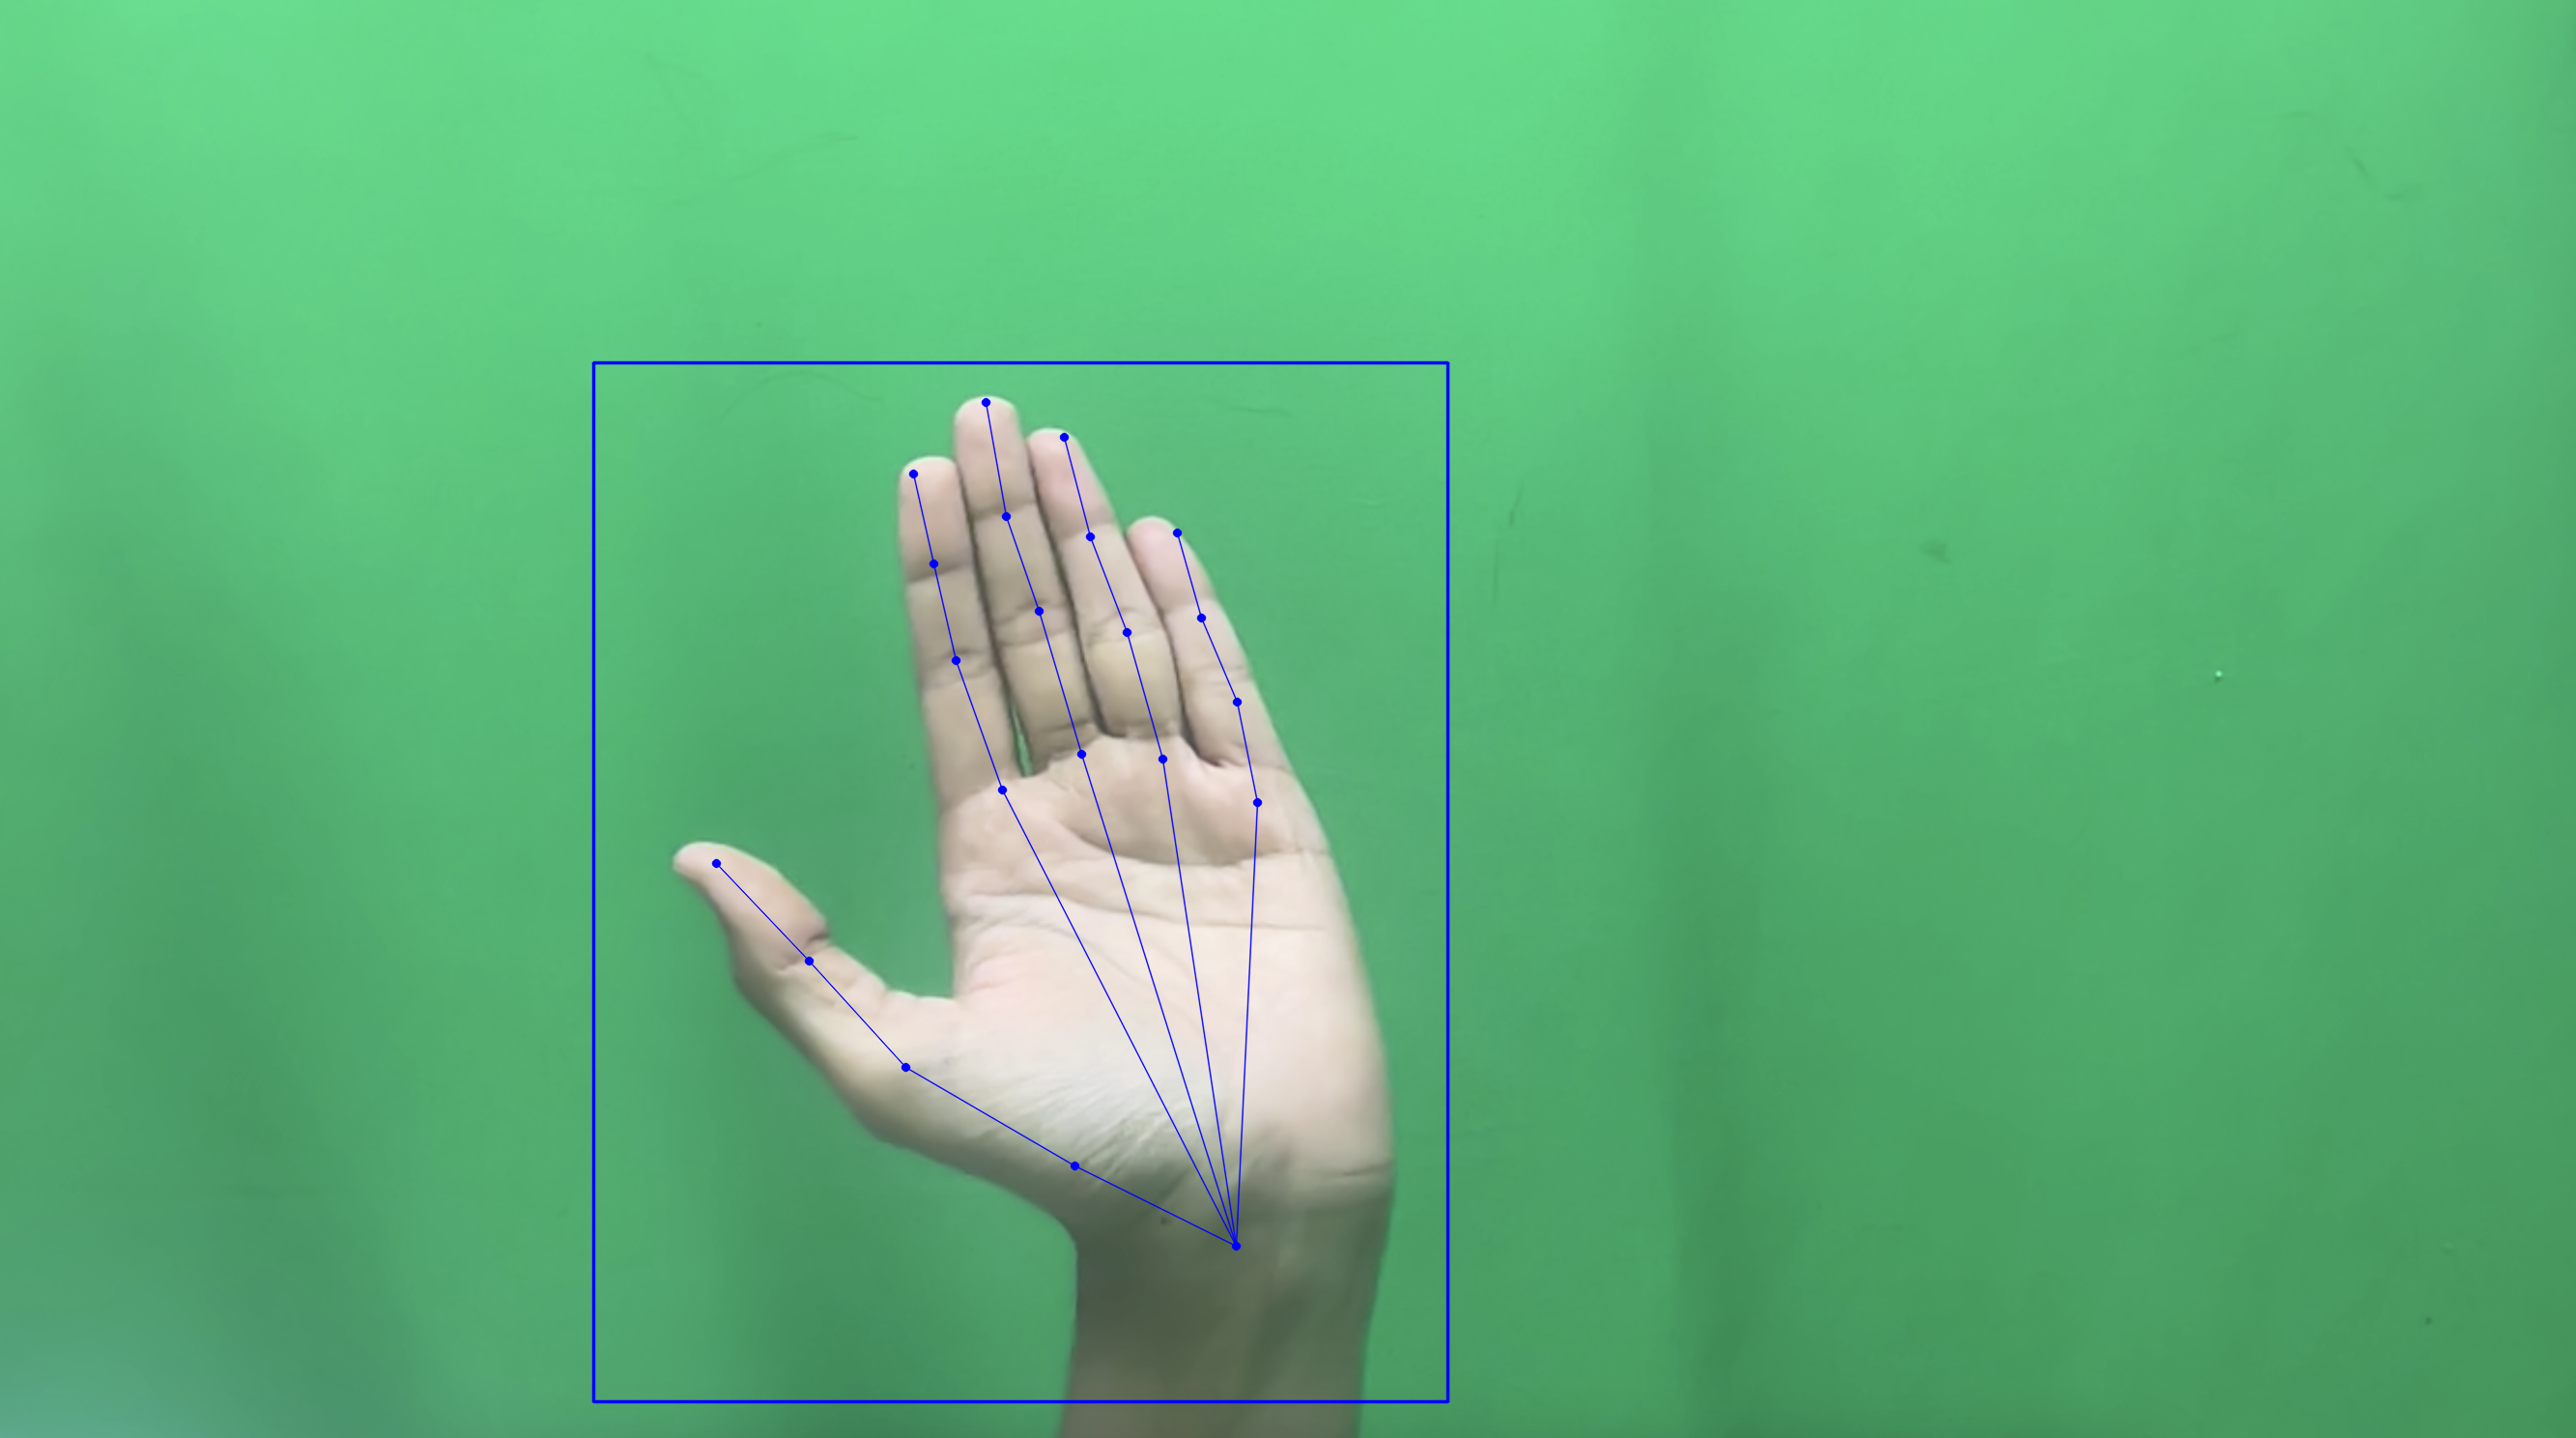

In [ ]:
#Making predictions with the best model we got
coco_images_dir = '/content/dataset/images'
coco_images_name = os.listdir(coco_images_dir)
img_name = np.random.choice(coco_images_name, size=1)[0]
img_path = os.path.join(coco_images_dir, img_name)
preds = best_model.predict(img_path, conf=0.3)
print(preds.prediction.scores)

image = preds.image
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
h, w, _ = image.shape

RECT_COLORS = [(255, 0, 0), (0, 0, 0), (0, 0, 255)]

for i in range(0, min(3, len(preds.prediction))):
    pose = preds.prediction.poses[i]
    bbox = preds.prediction.bboxes_xyxy[i]
    # print('[bbox]', bbox.shape)

    x1, y1, x2, y2 = bbox
    x1 = int(min(w, max(x1, 0)))
    y1 = int(min(h, max(y1, 0)))
    x2 = int(min(w, max(x2, 0)))
    y2 = int(min(h, max(y2, 0)))
    cv2.rectangle(image, (x1, y1), (x2, y2), RECT_COLORS[i], thickness=2, lineType=cv2.LINE_AA)

    for j, kpt in enumerate(pose):

        cv2.circle(image, kpt[:2].astype(np.int64), radius=4, color=RECT_COLORS[i], thickness=-1, lineType=cv2.LINE_AA)
    for k, pair in enumerate(preds.prediction.edge_links):
        pt1 = pose[pair[0]]
        pt2 = pose[pair[1]]

        cv2.line(image, pt1[:2].astype(np.int64), pt2[:2].astype(np.int64), color=RECT_COLORS[i], thickness=1, lineType=cv2.LINE_AA)

cv2_imshow(image)


# onnx export

In [ ]:
import cv2
from super_gradients.training import models
from super_gradients.common.object_names import Models

best_model = models.get('yolo_nas_pose_n',
                        num_classes=config['num_joints'],
                        checkpoint_path='/content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth')

export_result = best_model.export("yolo_nas_n.onnx")

[2024-08-02 19:52:29] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/python/ai-pointer/hand_pose-007-yolo_nas_n/RUN_20240802_062811_035752/ckpt_best.pth EMA checkpoint.
/usr/local/lib/python3.10/dist-packages/super_gradients/conversion/onnx/pose_nms.py:73: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  selected_indexes = torch.cat([torch.tensor([[-1, -1, -1]], device=selected_indexes.device, dtype=selected_indexes.dtype), selected_indexes], dim=0)
/usr/local/lib/python3.10/dist-packages/torch/onnx/symbolic_opset9.py:5858: UserWarning: Exporting aten::index operator of advanced indexing in opset 17 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, 

In [ ]:
export_result


Model exported successfully to yolo_nas_n.onnx
Model expects input image of shape [1, 3, 640, 640]
Input image dtype is torch.uint8

Exported model already contains preprocessing (normalization) step, so you don't need to do it manually.
Preprocessing steps to be applied to input image are:
Sequential(
  (0): CastTensorTo(dtype=torch.float32)
  (1): ApplyMeanStd(mean=[[[0.485 0.456 0.406]]], scale=[[[0.229 0.224 0.225]]])
)


Exported model contains postprocessing (NMS) step with the following parameters:
    num_pre_nms_predictions=1000
    max_predictions_per_image=1000
    nms_threshold=0.7
    confidence_threshold=0.05
    output_predictions_format=batch


Exported model is in ONNX format and can be used with ONNXRuntime
To run inference with ONNXRuntime, please use the following code snippet:

    import onnxruntime
    import numpy as np
    session = onnxruntime.InferenceSession("yolo_nas_n.onnx", providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
    inputs = [o.name

---